In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import time

In [3]:
file_path = "Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.0001.csv"
data = pd.read_csv(file_path)
filtered_data = data[data['PEEQ'] <= 3]
PEEQ = filtered_data["PEEQ"].to_numpy()
PEEQ_fit = np.linspace(np.min(PEEQ), np.max(PEEQ), 200)

Parameter: C1, R^2: 0.9978, Coefficients: [-5.13146695e-01  5.11896000e-32  9.76086723e-02 -2.53378231e+01
  7.14891597e-08  7.63241520e+00  3.77877953e+00  3.97812477e+00
  4.59178450e+01  4.19456159e-08]
Parameter: C2, R^2: 0.8492, Coefficients: [-4.86111568e-03  1.76573793e-01  5.34722780e-01 -2.64016176e+00
  2.00768237e-06  7.54665960e-10  1.03717231e+00  1.00000010e-03
  5.29828448e+00  4.94270357e-04]
Parameter: C3, R^2: 0.9884, Coefficients: [ 5.03594212e-01  4.48478765e-03  4.45127019e-03 -3.50694926e+01
  8.83901750e-08  2.70668842e-01  1.68743972e+00  6.73526408e-01
  7.07987011e+01  8.20852363e-03]
Parameter: C4, R^2: 0.9136, Coefficients: [-5.15155805e-01  5.12010174e-17  9.84640632e-02 -1.85734576e+00
  8.67683777e-23  3.94816552e-04  1.81541432e+00  1.00411355e-03
  6.09597896e+00  4.96606028e-22]
Parameter: C5, R^2: 0.9900, Coefficients: [ 6.36559584e+01  9.81563278e-37  3.50943211e-01 -9.02960065e+01
  1.85213995e+02  1.73690128e+01  8.17948048e-01  3.44410319e-01
  1.

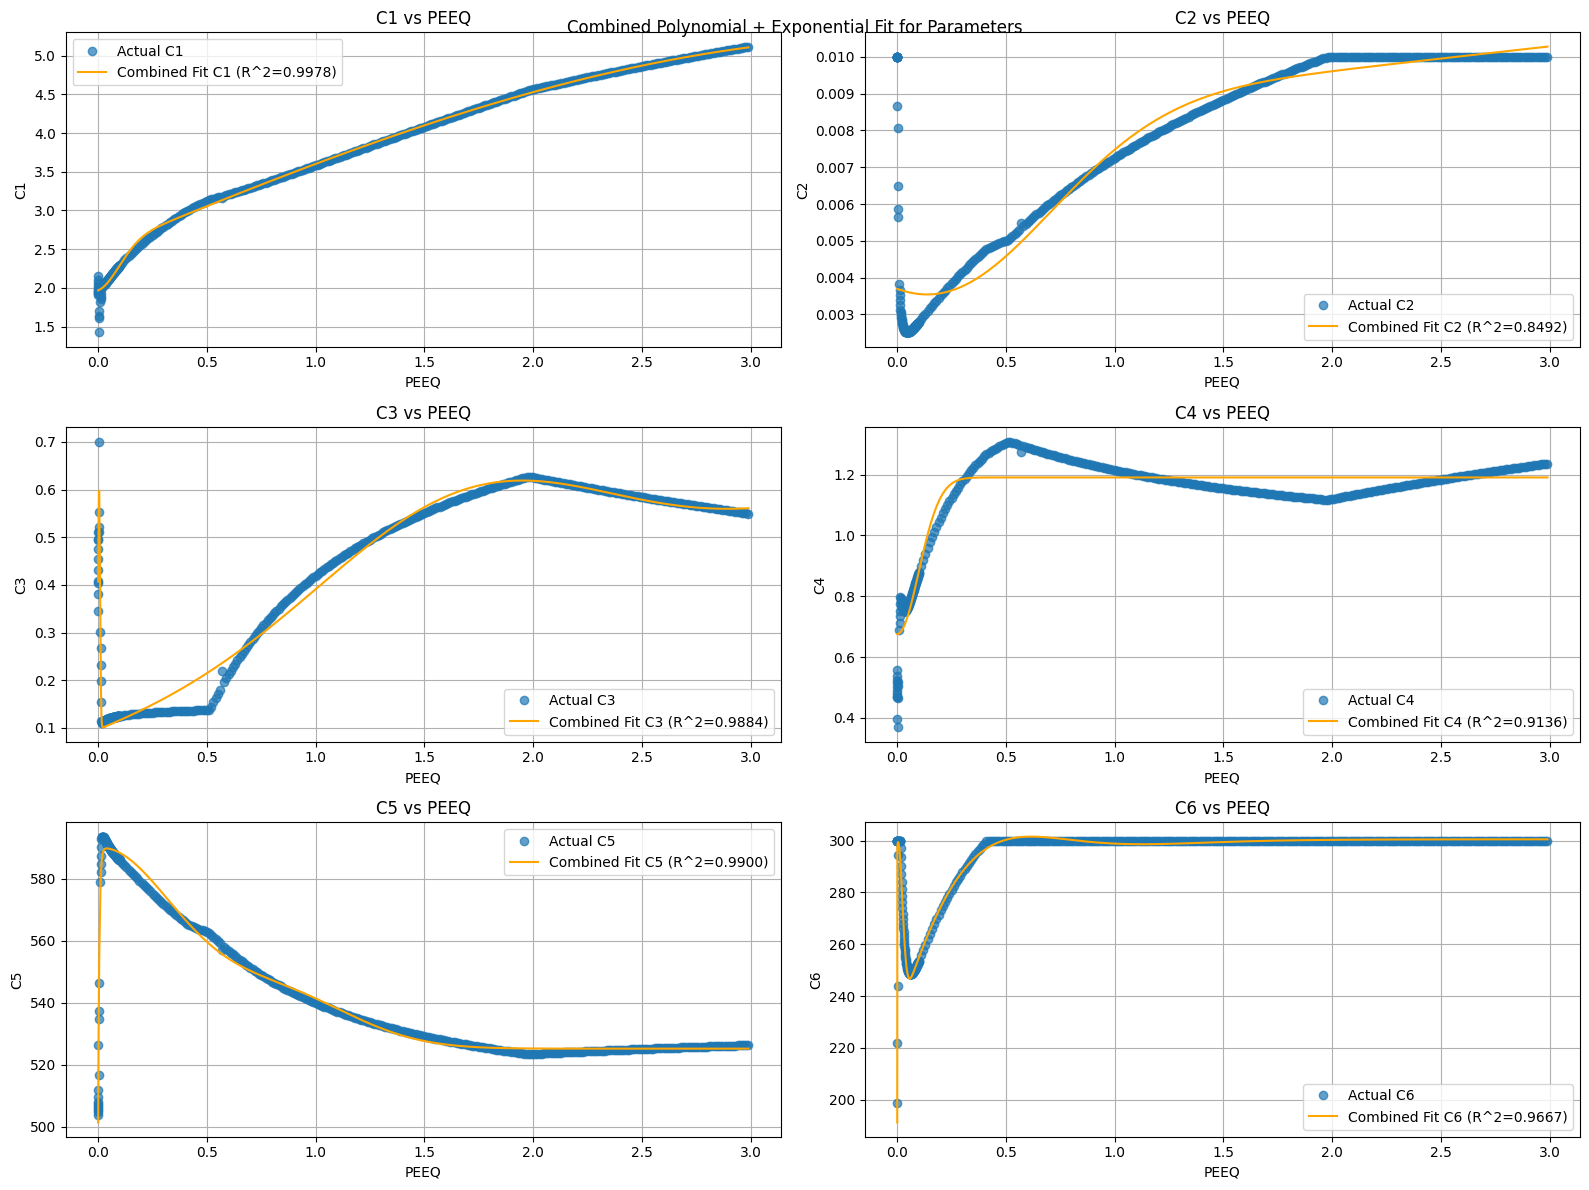

In [10]:
df_para_fit = pd.DataFrame(PEEQ, columns=["PEEQ"])

# Define the combined polynomial + exponential function
def combined_fit(s, a, b, c, d, e, f, g, h, i, j):
    gaussian1 = a * np.exp(-((s - b)**2) / (2 * c**2))  # First Gaussian for initial increase
    decay = d * np.exp(-e * s)  # Exponential decay for rapid drop
    gaussian2 = f * np.exp(-((s - g)**2) / (2 * h**2))  # Second Gaussian for the rise
    logistic = i / (1 + np.exp(-j * (s - g)))  # Logistic function for final leveling off
    return gaussian1 + decay + gaussian2 + logistic

# Function to fit the combined model and calculate R^2 score
def fit_combined_model(data, parameter):
    x = data['PEEQ']
    y = data[parameter]
    
    initial_guess = [10, 0.002, 0.001, -150, 5, 200, 1.5, 0.2, 300, 1]  # Adjusted initial guesses
    bounds = ([-np.inf, 0, 0.001, -np.inf, 0, 0, 0, 0.001, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    fit_warg = {'p0': initial_guess, 'bounds': bounds}
    # Fit the combined model
    try:
        popt, _ = curve_fit(combined_fit, x, y, maxfev=1000000, **fit_warg)
        y_pred = combined_fit(x, *popt)
        r2 = r2_score(y, y_pred)
    except RuntimeError:
        popt = None
        y_pred = None
        r2 = -np.inf  # Indicate failed fit
    
    if popt is not None:
        print(f'Parameter: {parameter}, R^2: {r2:.4f}, Coefficients: {popt}')
    else:
        print(f'Parameter: {parameter} - Fit failed')
    
    return popt, y_pred, r2

# List of parameters to fit
parameters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Fit models and plot results
plt.figure(figsize=(16, 12))

for i, param in enumerate(parameters):
    popt, y_pred, r2 = fit_combined_model(data, param)
    x = data['PEEQ']
    y_actual = data[param]
    df_para_fit[param] = y_pred
    
    plt.subplot(3, 2, i + 1)
    plt.plot(x, y_actual, 'o', label=f'Actual {param}', alpha=0.7)
    
    # Plot fitted combined model if successful
    if y_pred is not None:
        plt.plot(x, y_pred, '-', color='orange', label=f'Combined Fit {param} (R^2={r2:.4f})')
    
    plt.xlabel('PEEQ')
    plt.ylabel(param)
    plt.title(f'{param} vs PEEQ')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Combined Polynomial + Exponential Fit for Parameters')
plt.show()

In [11]:
df_para_fit.to_csv('para_fit_results_0.0001.csv', index=False)
# Assuming the file is one level up from the current directory
file_path = "Fitted_FC_TmpDpn_RD_StrRt0.0001_ref.csv"
stress_data = pd.read_csv(file_path)

fitted_para = pd.read_csv('para_fit_results_0.0001.csv')

[1.38362624 0.75022644 0.59327141 0.78766057 0.86840388 0.84906686
 0.69294547]


/tmp/ipykernel_105521/2046241503.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


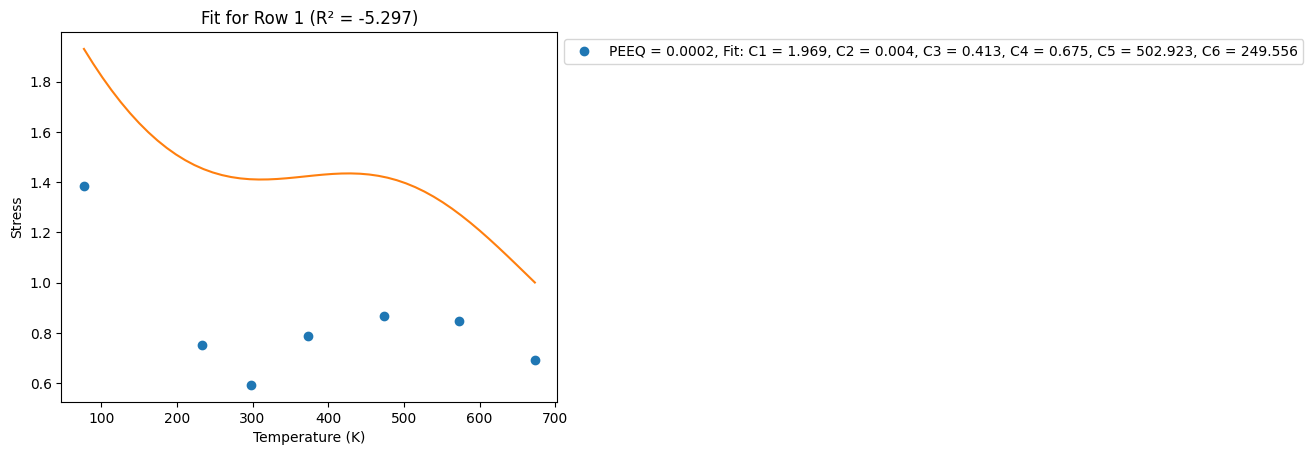

[1.4194923  0.80649924 0.83371755 0.86048538 0.93187057 0.8998833
 0.78170283]


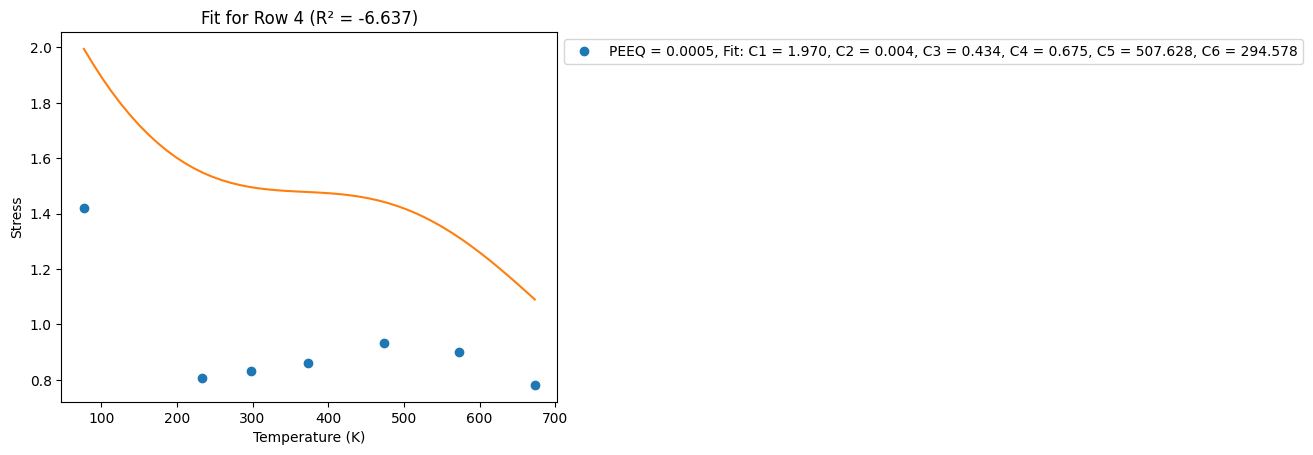

[1.44620157 0.85516599 0.88630538 0.90150049 0.96913261 0.93541711
 0.82496054]


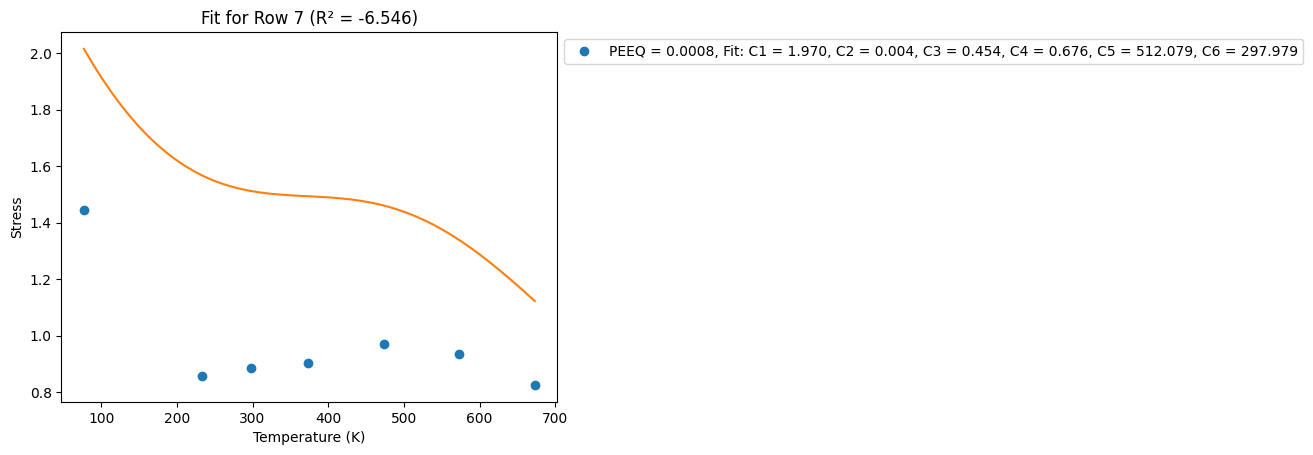

[1.46805583 0.89619448 0.92251927 0.93004991 0.99464934 0.96183385
 0.85385738]


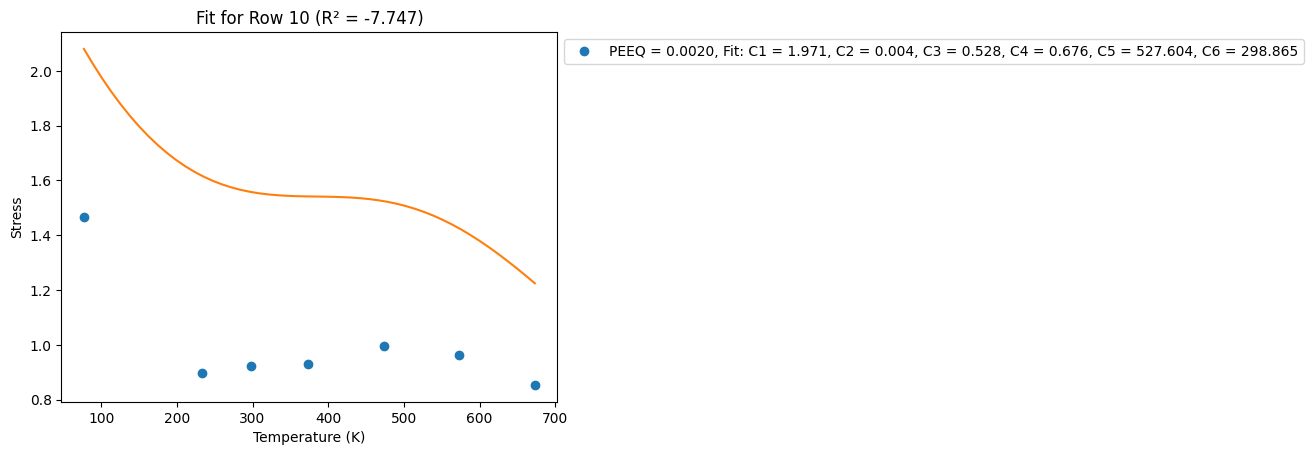

[1.59357241 1.10176648 1.08034605 1.05736171 1.11566215 1.08573979
 0.97677816]


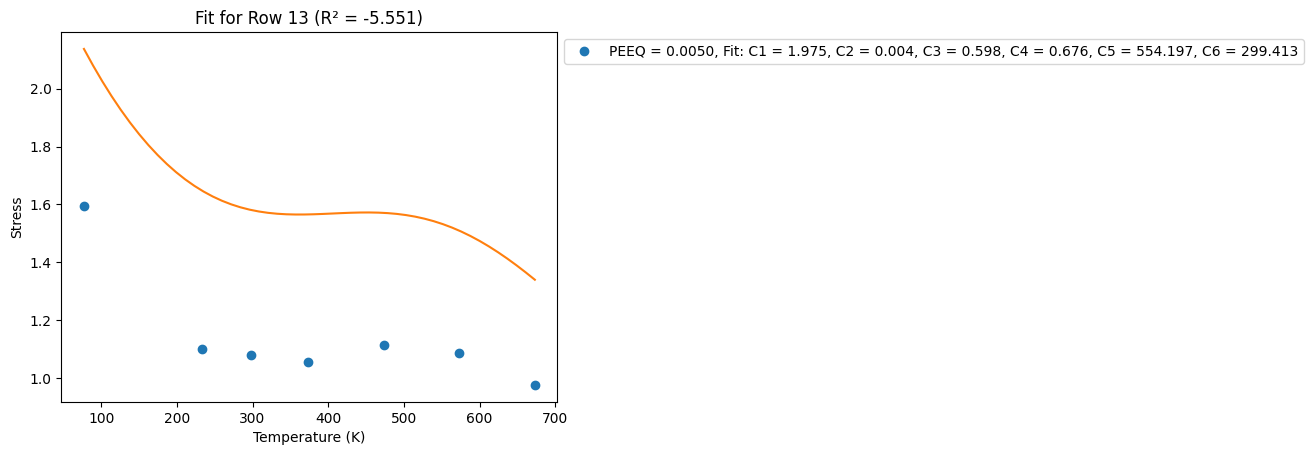

[1.70359577 1.23074727 1.19060952 1.1640928  1.22051093 1.20278589
 1.07190862]


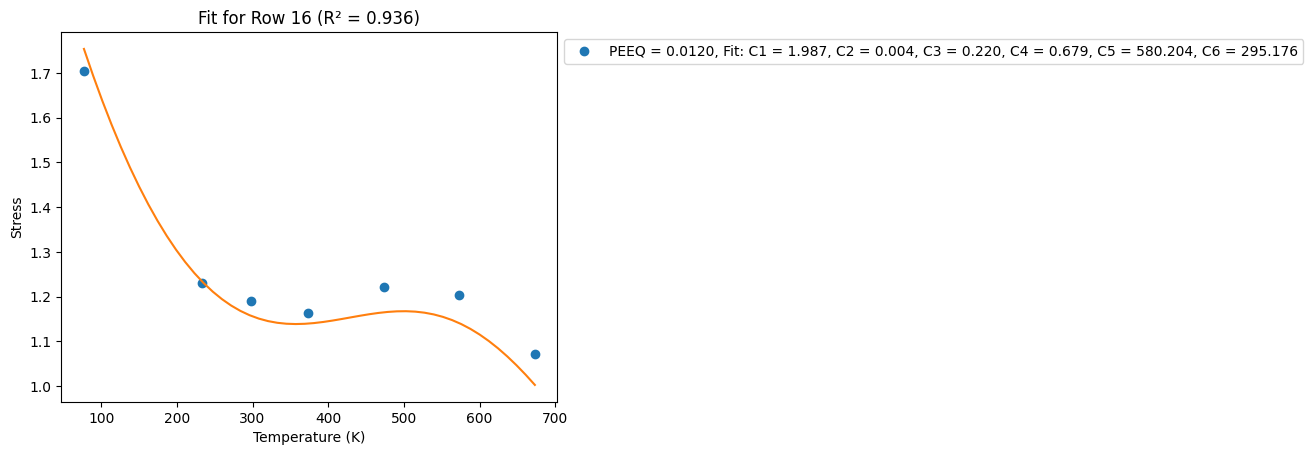

[1.72864721 1.25864129 1.21475    1.18961502 1.24586552 1.23303866
 1.09329532]


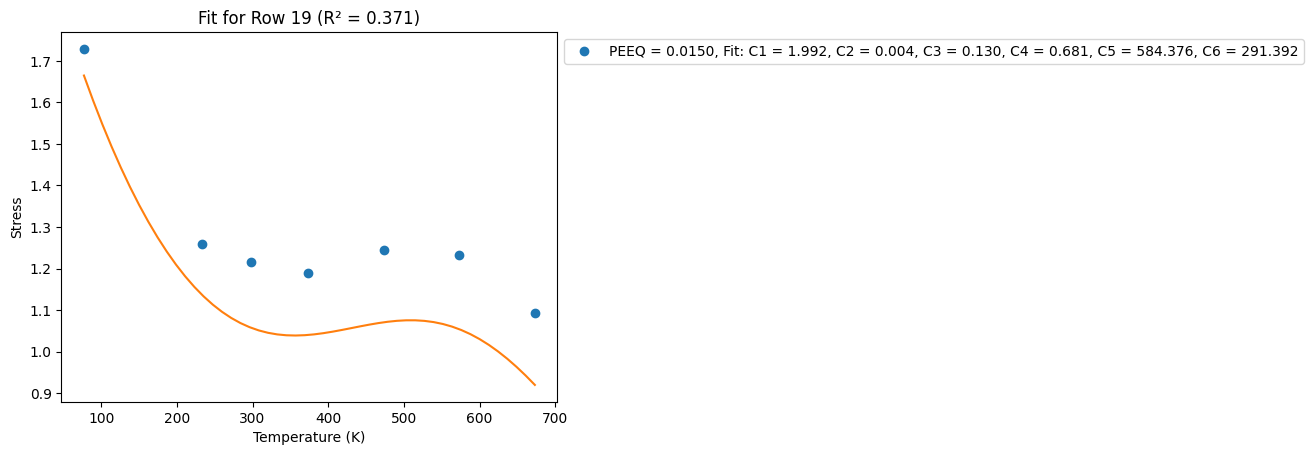

[1.74896644 1.28129345 1.23350345 1.20965377 1.26618549 1.25746864
 1.10987435]


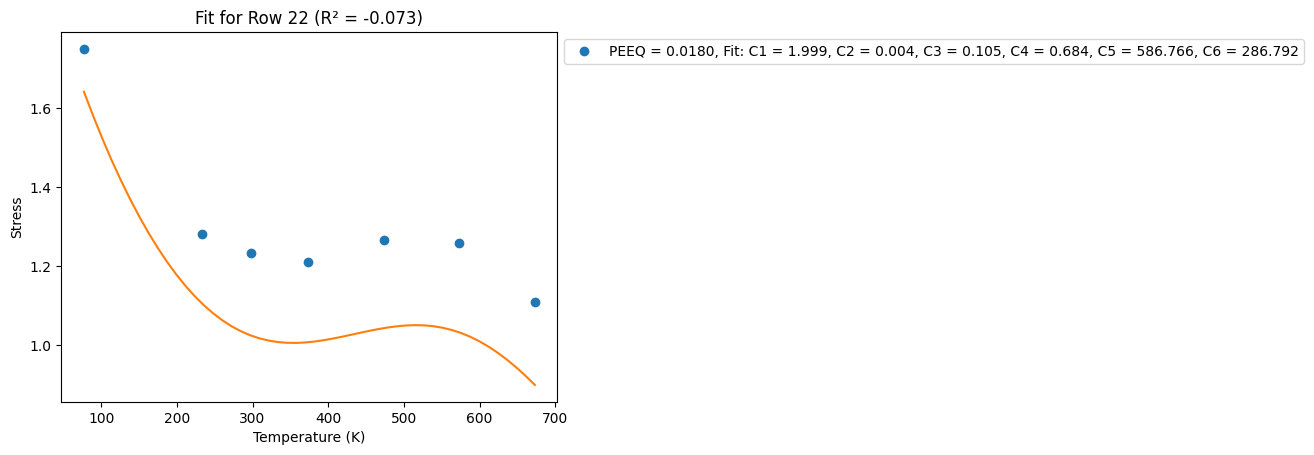

[1.76639812 1.30030023 1.24872655 1.22594285 1.28309271 1.27786607
 1.12333138]


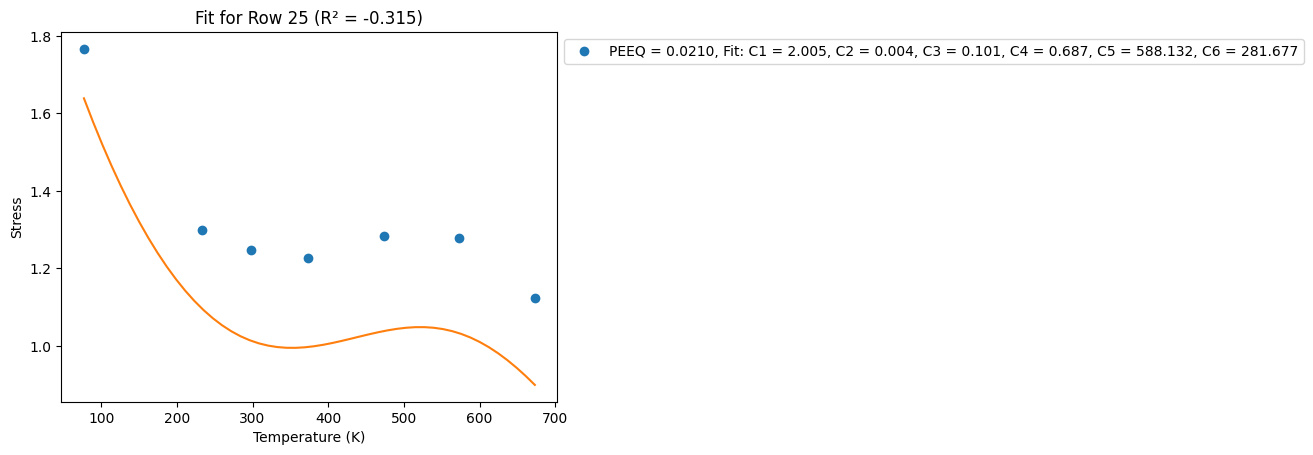

[1.78187729 1.31646755 1.26147097 1.23954674 1.2975392  1.2953347
 1.13464038]


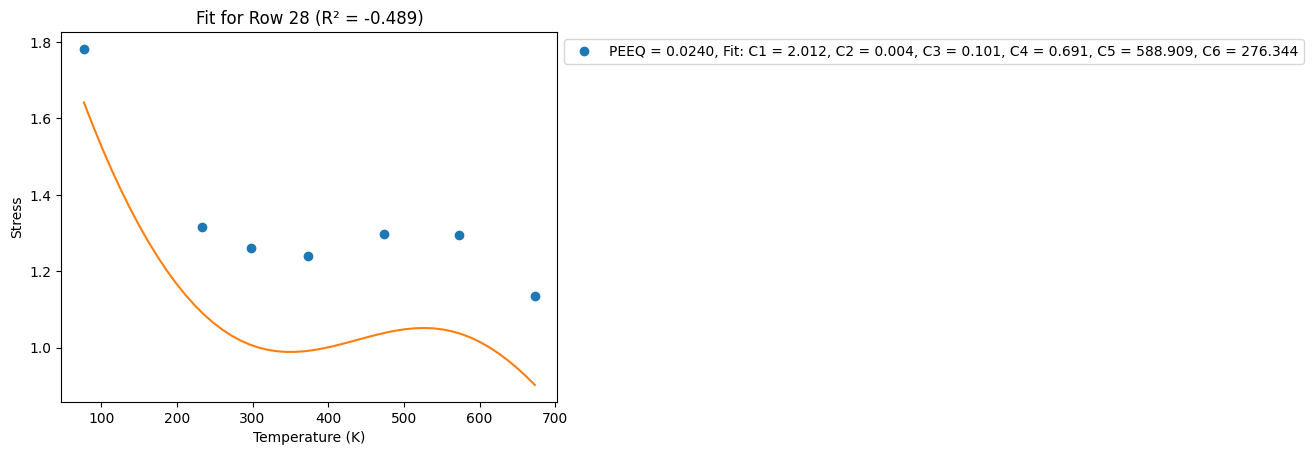

[1.79592275 1.33031861 1.27238701 1.25116248 1.31013038 1.31059035
 1.14439984]


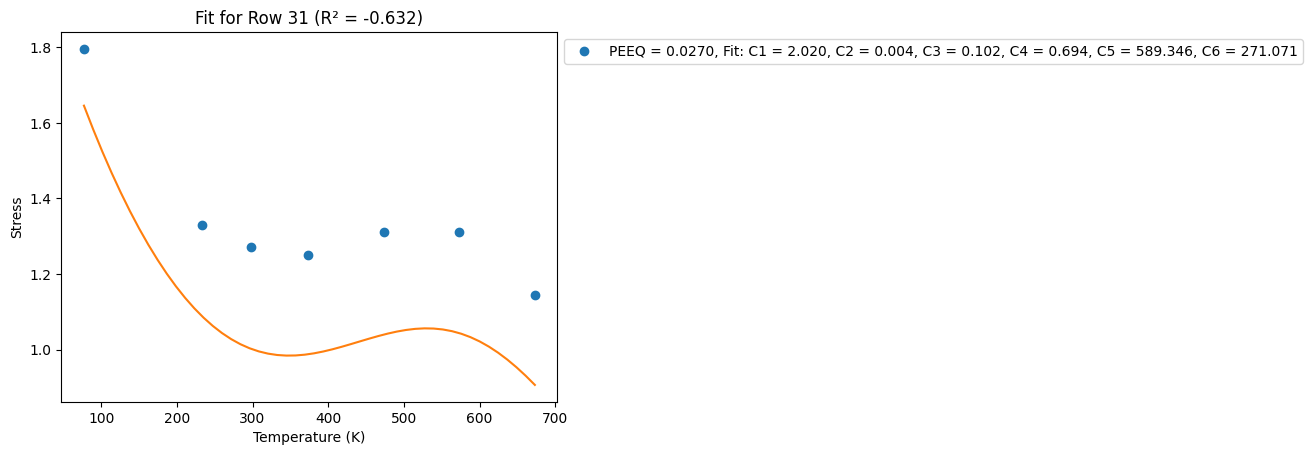

[1.80885015 1.34225003 1.28190331 1.26126641 1.32127459 1.3241189
 1.15299558]


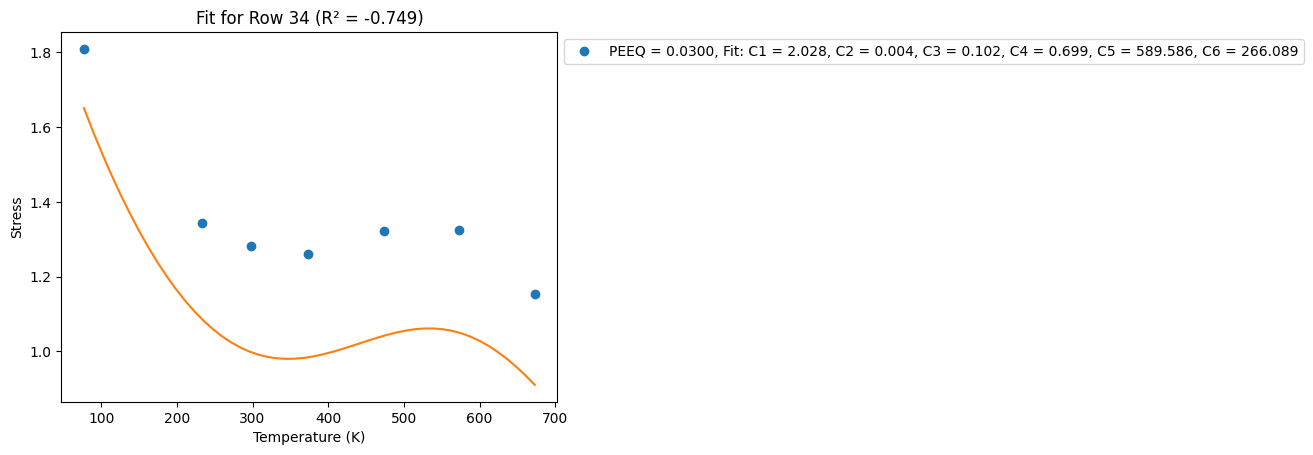

[1.8208684  1.35258276 1.29031645 1.27019433 1.33125993 1.33626369
 1.16068687]


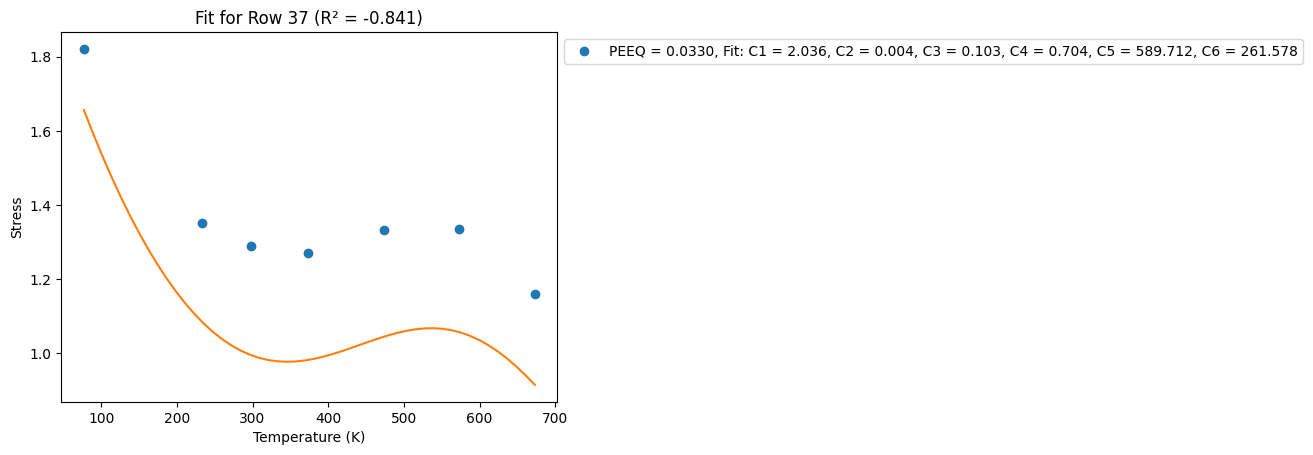

[1.83212564 1.36158161 1.29783969 1.2781888  1.34029708 1.34727573
 1.16765452]


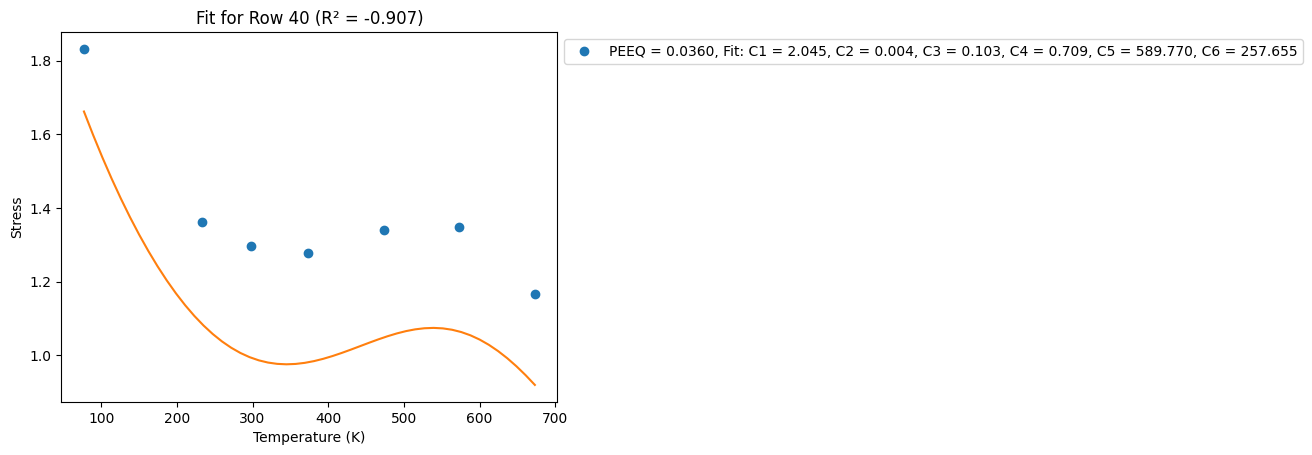

[1.8427326  1.36946531 1.3046312  1.28542859 1.34854463 1.35734389
 1.17402896]


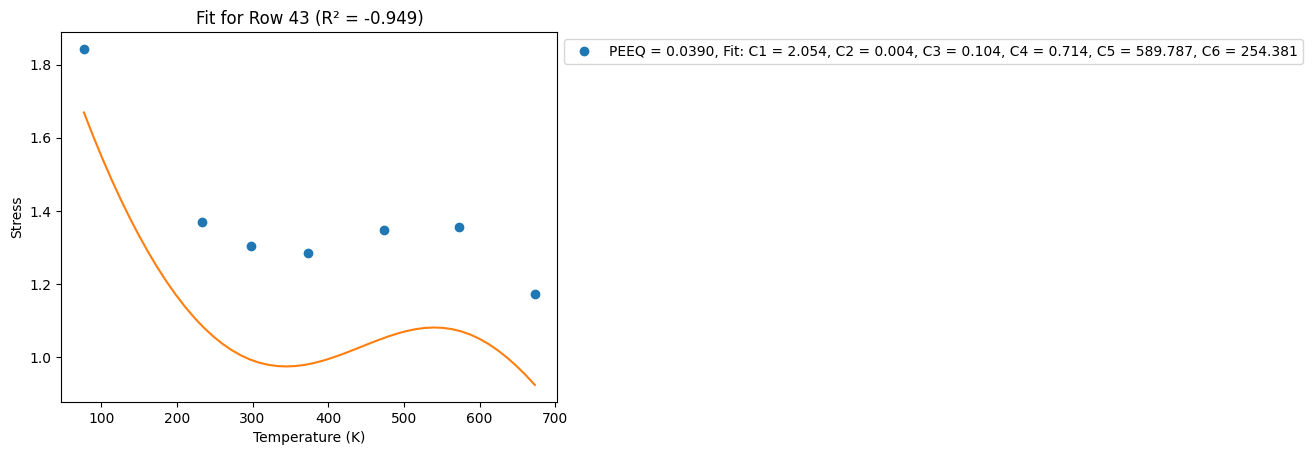

[1.85277529 1.37641401 1.31081134 1.29204793 1.35612486 1.36661375
 1.17990724]


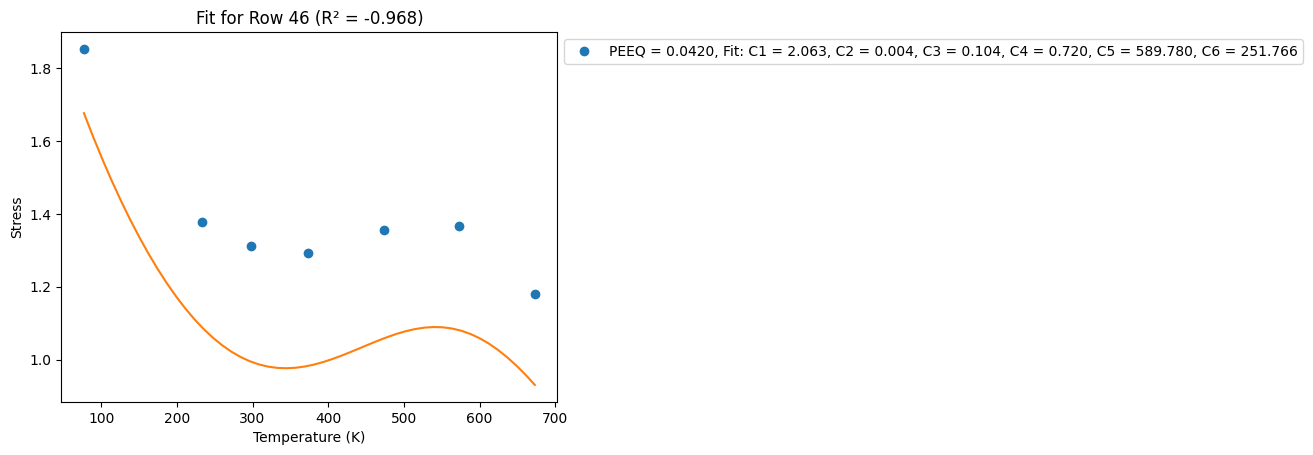

[1.86232241 1.38257565 1.31647371 1.29814923 1.363134   1.37519986
 1.18536358]


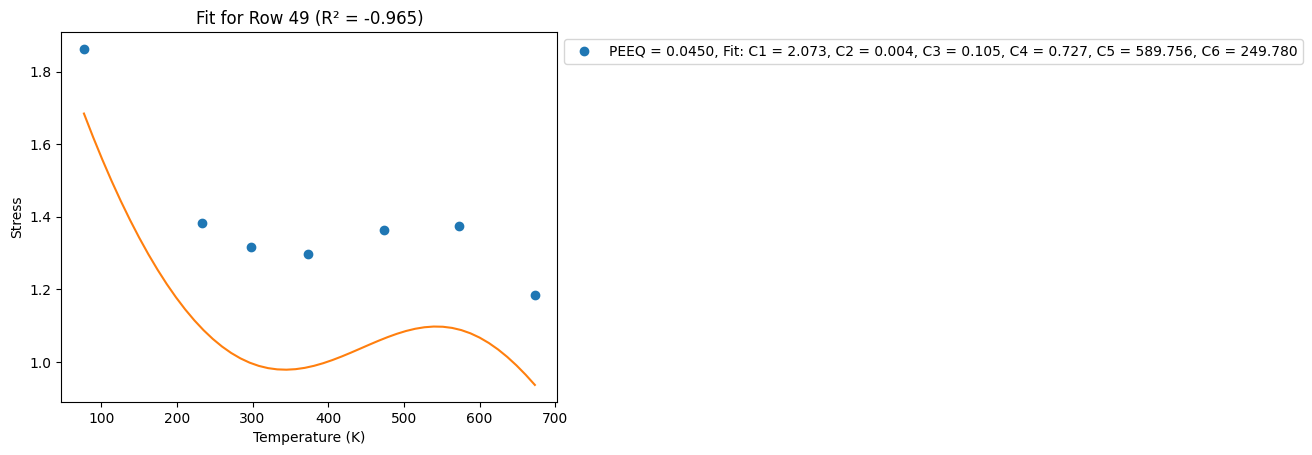

[1.87143004 1.38807155 1.32169241 1.30381188 1.36964908 1.38319392
 1.19045608]


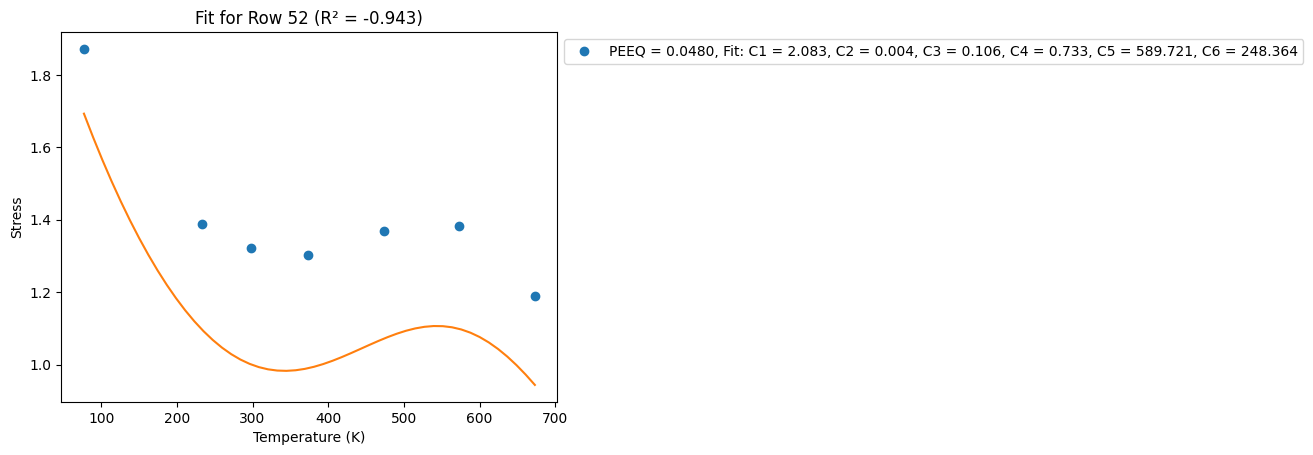

[1.88014466 1.39300126 1.3265271  1.30909832 1.37573273 1.39067049
 1.19523123]


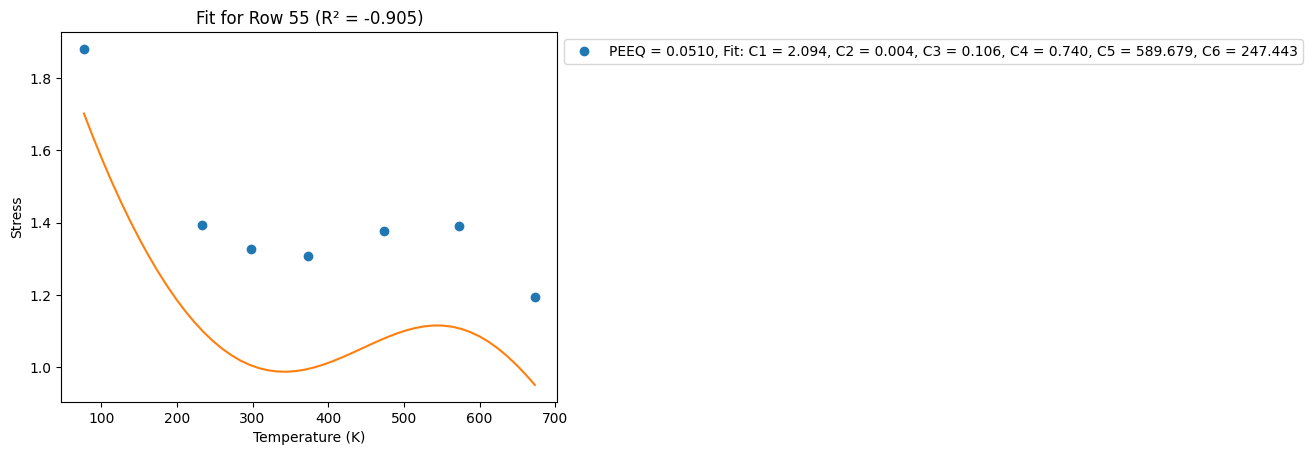

[1.88850538 1.39744661 1.33102644 1.3140584  1.38143649 1.39769095
 1.19972686]


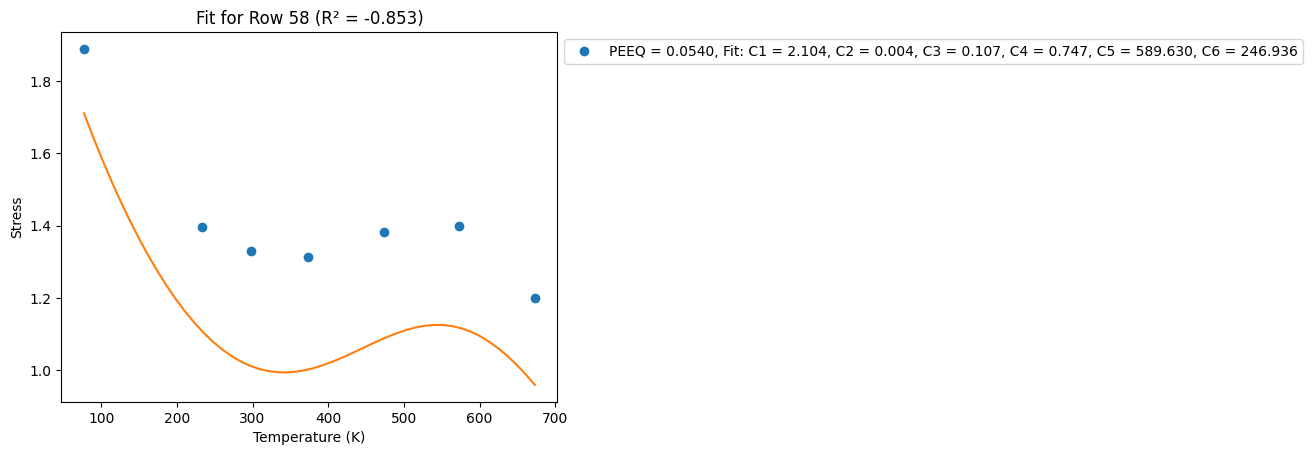

[1.89654542 1.40147518 1.33523062 1.31873243 1.38680331 1.40430647
 1.20397426]


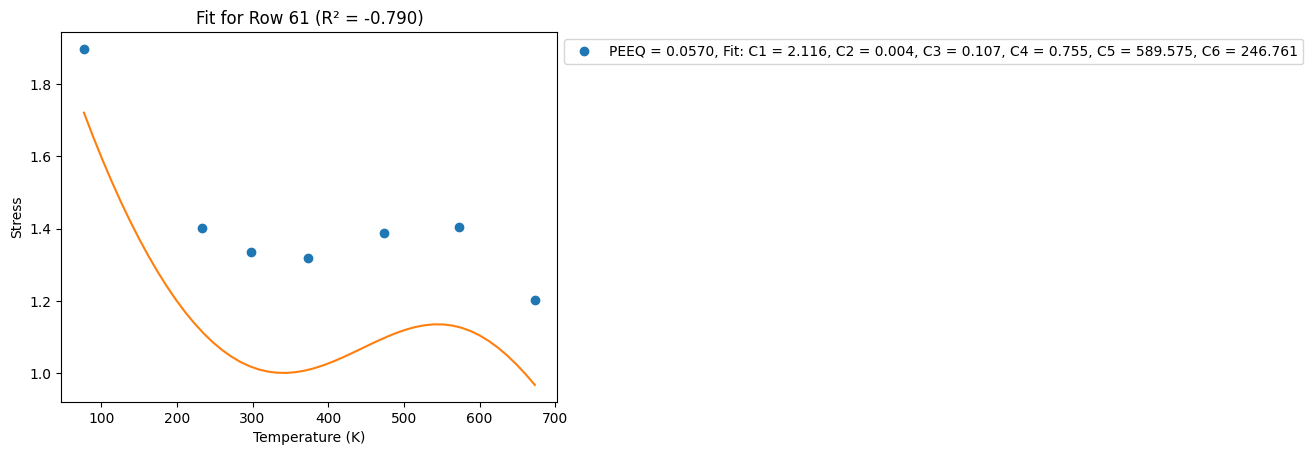

[1.90429329 1.40514294 1.33917319 1.32315342 1.39186932 1.41056014
 1.20799963]


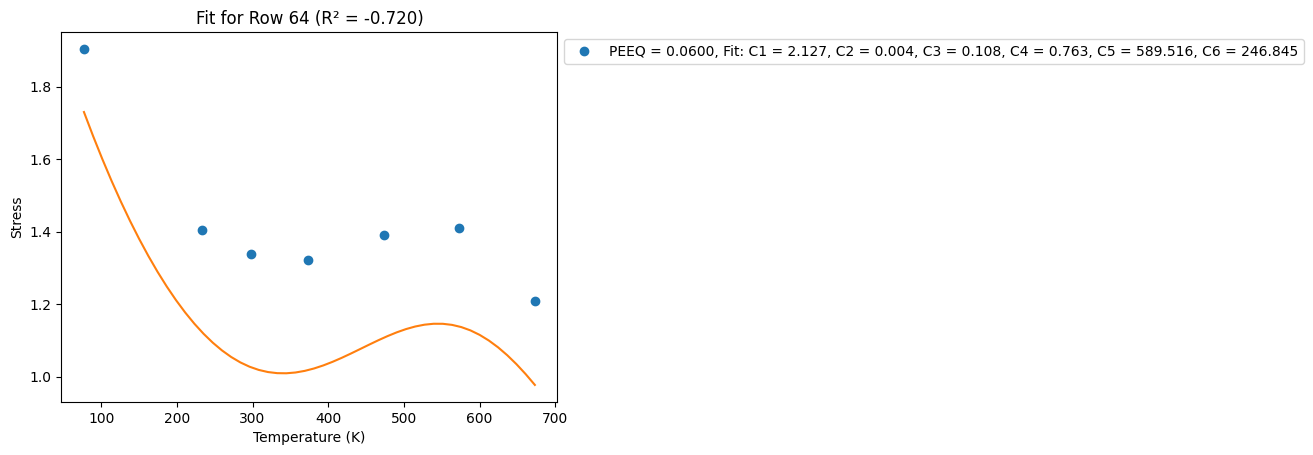

[1.91177367 1.40849654 1.34288243 1.32734877 1.39666522 1.41648856
 1.21182517]


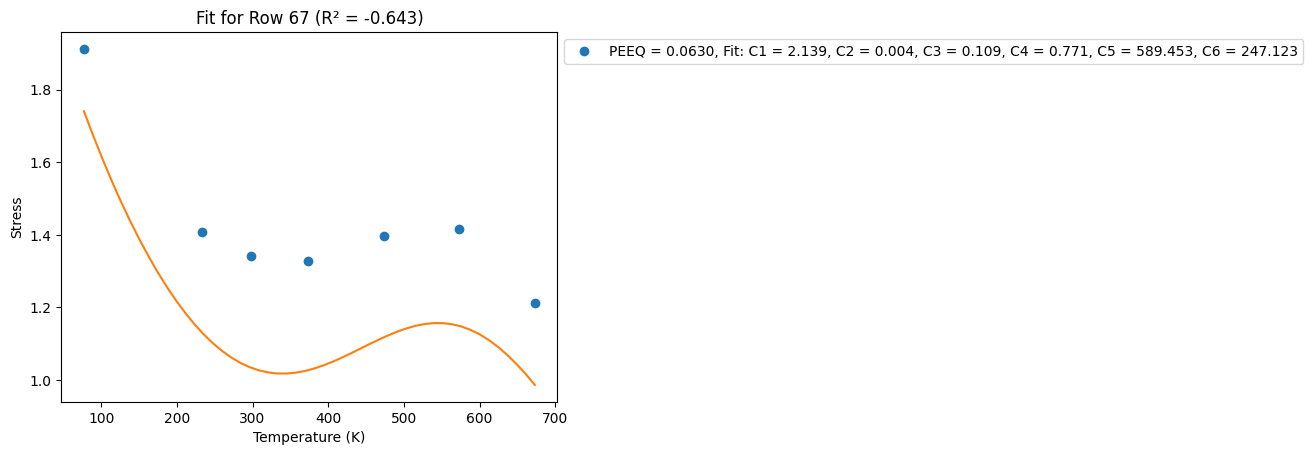

[1.91900808 1.41157508 1.34638239 1.33134145 1.40121729 1.42212307
 1.21546985]


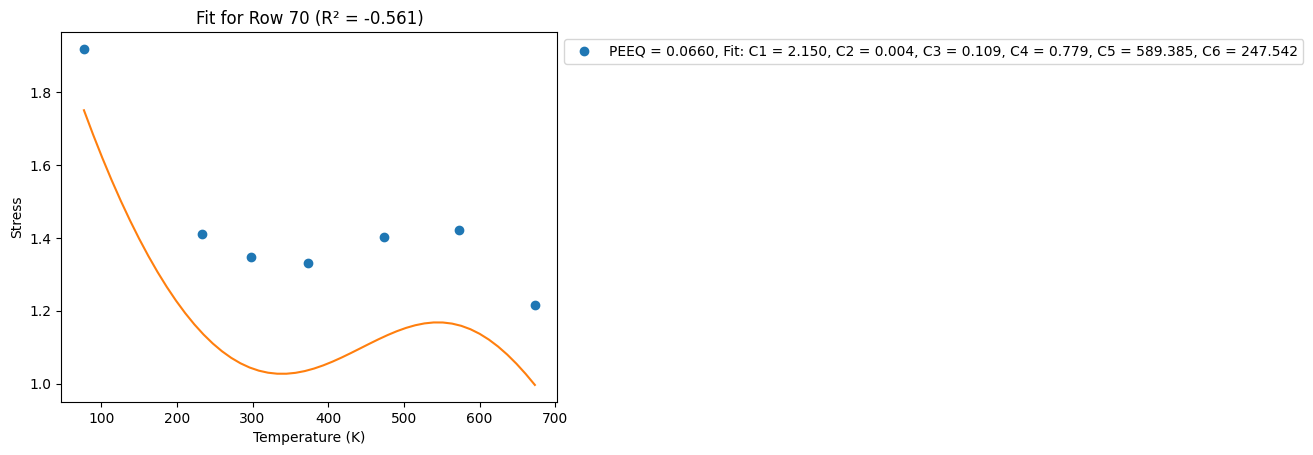

[1.92601541 1.41441147 1.34969369 1.33515093 1.40554819 1.42749076
 1.21895006]


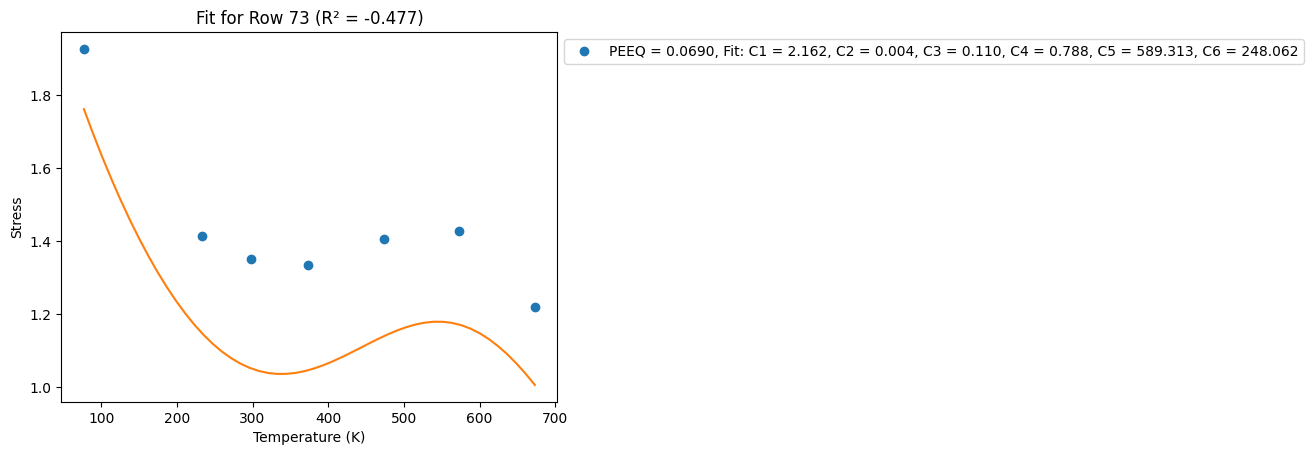

[1.93281234 1.41703362 1.3528341  1.33879387 1.40967761 1.43261513
 1.22228003]


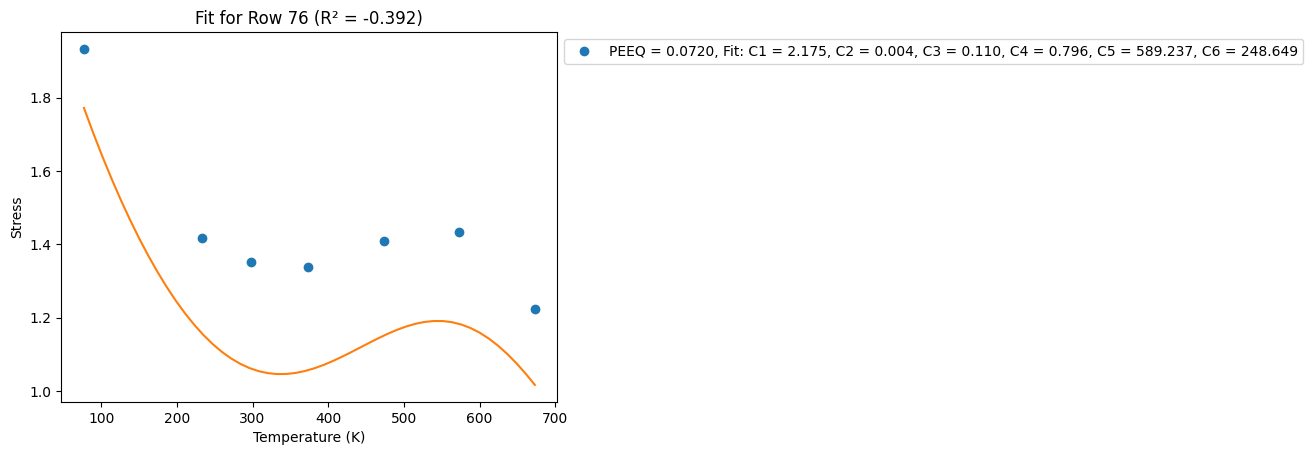

[1.93941366 1.41946533 1.35581908 1.34228465 1.41362276 1.43751676
 1.22547221]


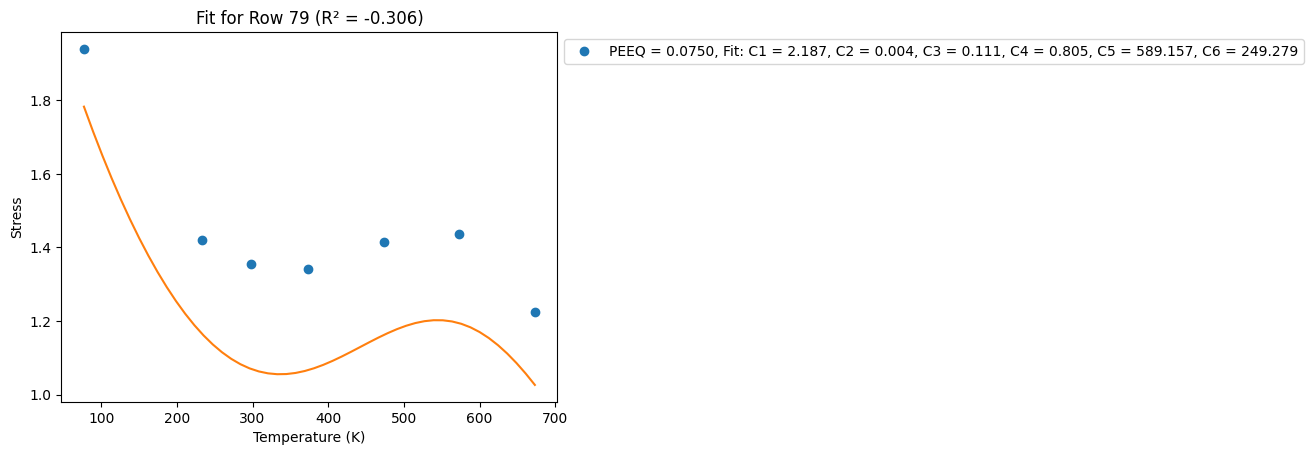

[1.94583261 1.42172698 1.35866212 1.3456358  1.41739874 1.44221373
 1.22853757]


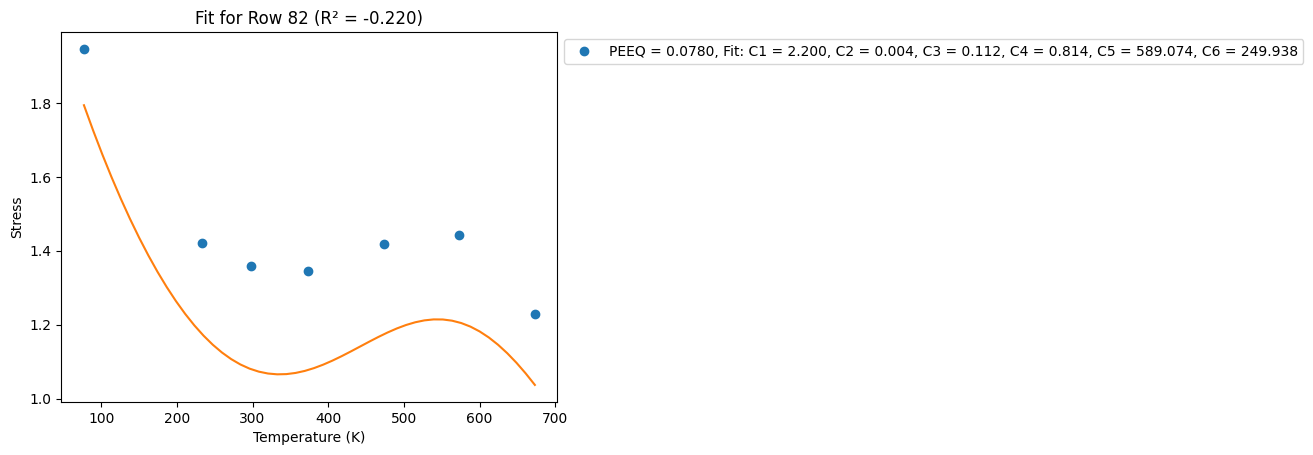

[1.95208104 1.42383615 1.36137509 1.34885829 1.42101893 1.44672204
 1.2314858 ]


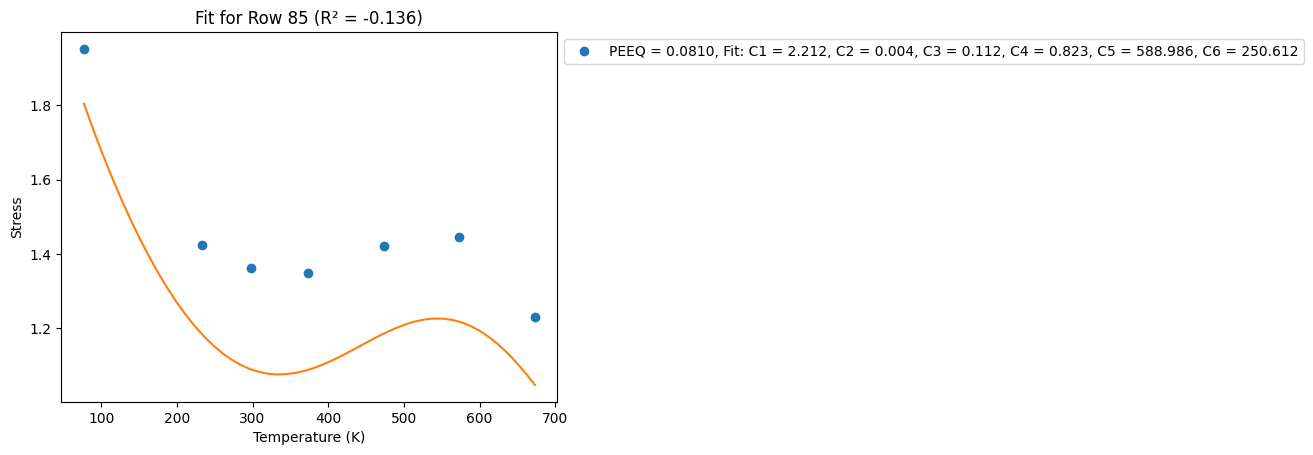

[1.95816961 1.42580803 1.36396847 1.3519618  1.42449516 1.45105586
 1.23432553]


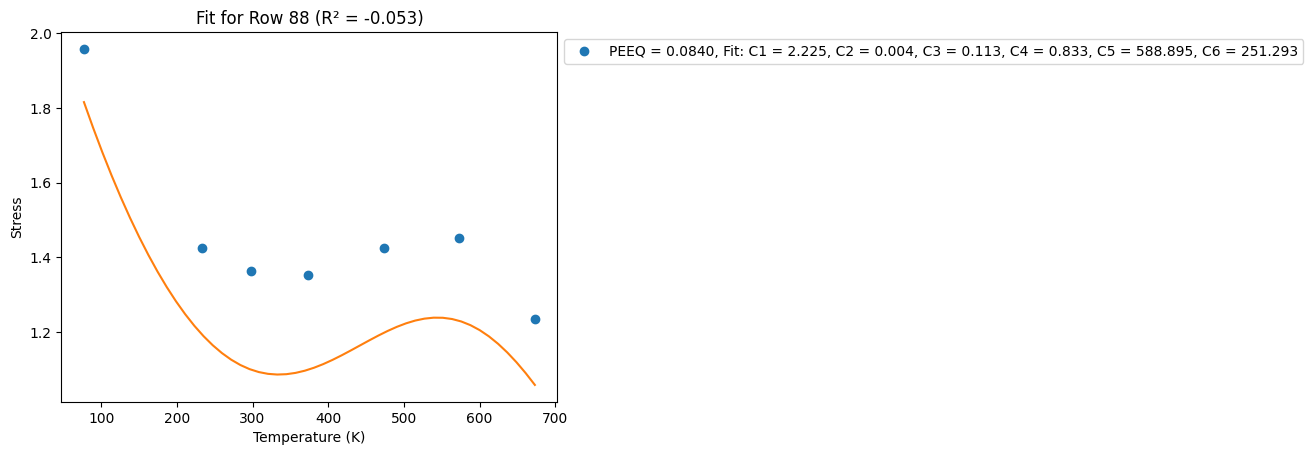

[1.96410797 1.42765589 1.36645154 1.35495494 1.42783802 1.45522789
 1.23706446]


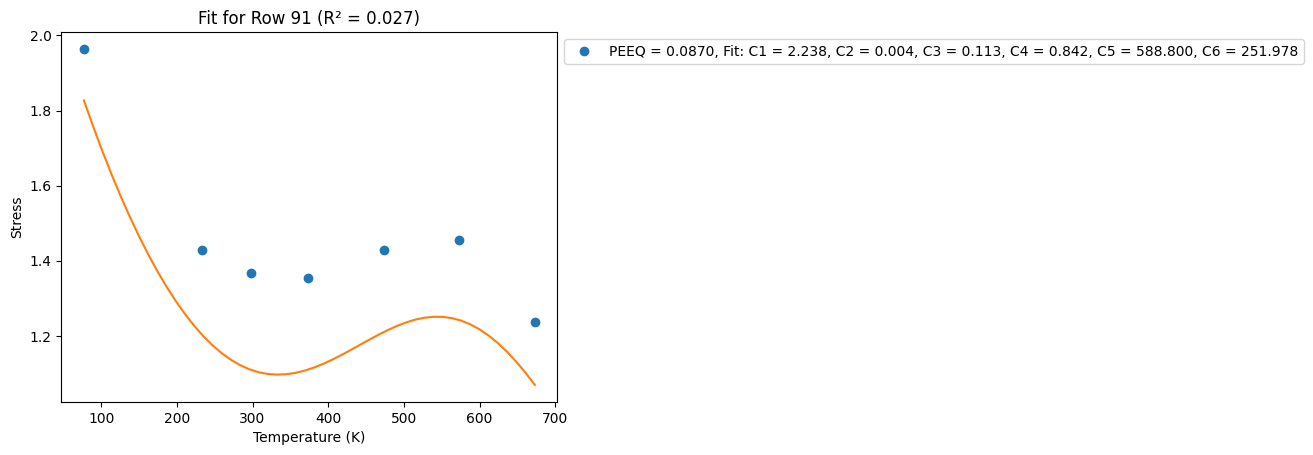

[1.96990487 1.42939131 1.36883258 1.35784537 1.43105695 1.45924945
 1.23970951]


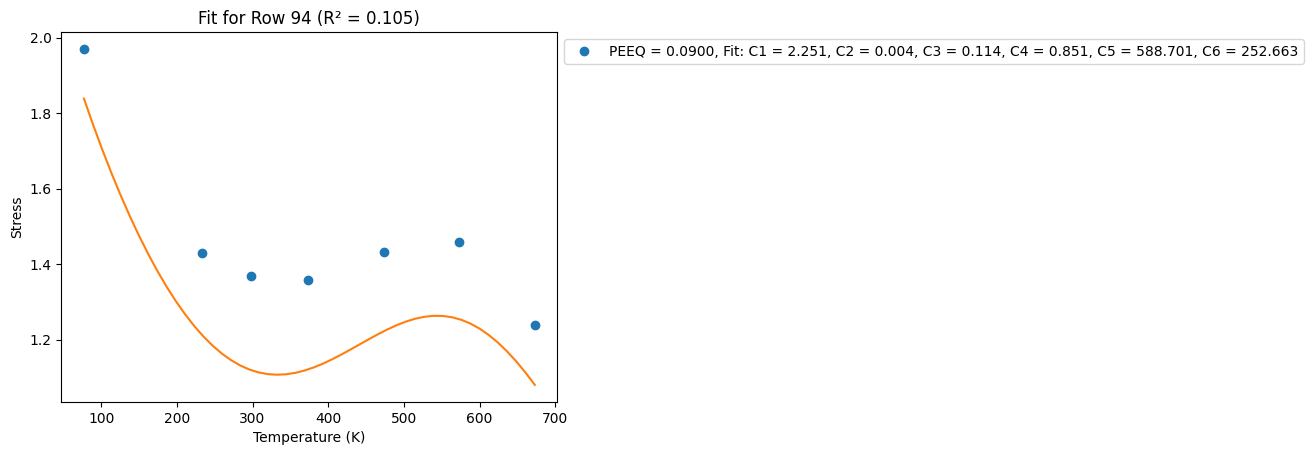

[1.97556828 1.43102444 1.371119   1.36063998 1.43416046 1.46313076
 1.24226691]


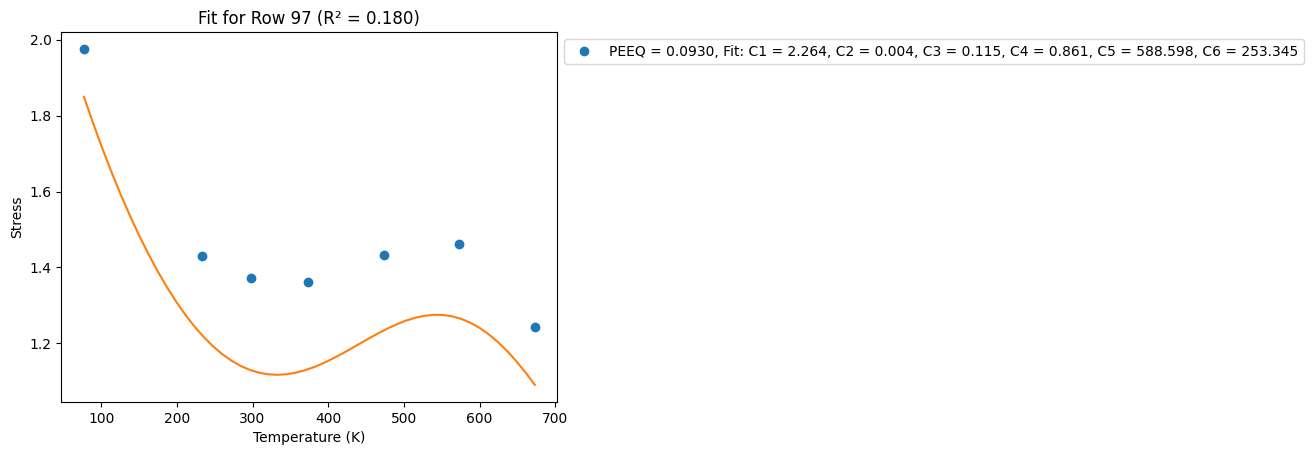

[1.98110548 1.43256427 1.37331745 1.36334497 1.43715622 1.46688103
 1.24474227]


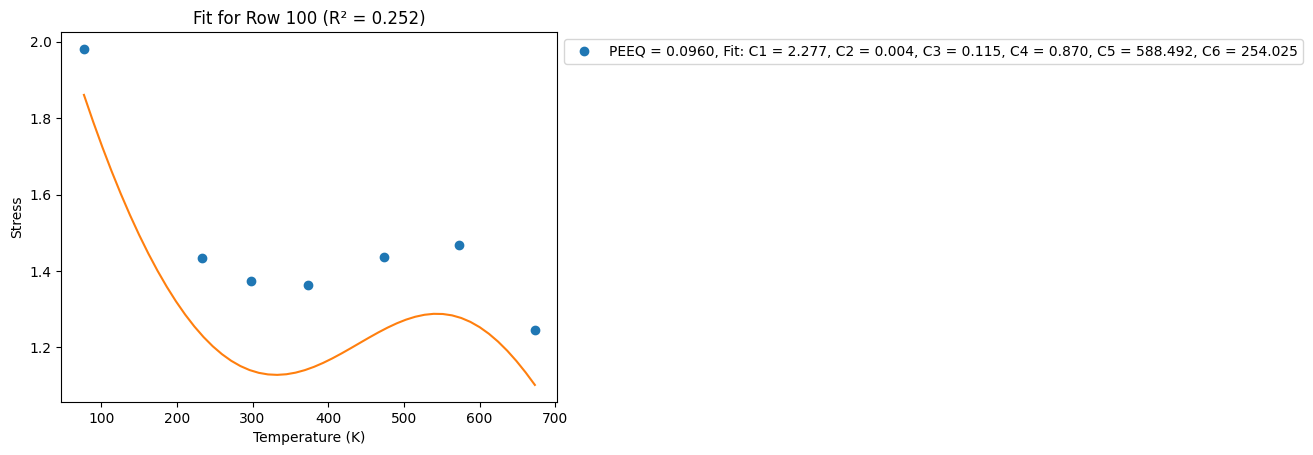

[1.98652313 1.43401873 1.37543392 1.36596594 1.44005116 1.47050858
 1.24714069]


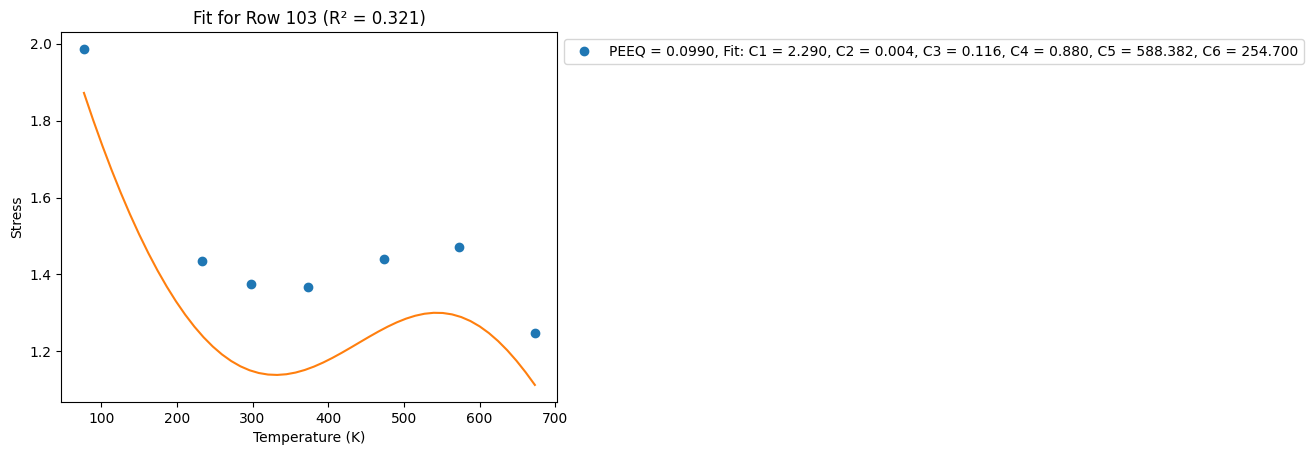

[2.0071137  1.43911315 1.38318112 1.3757049  1.45074066 1.48393353
 1.256052  ]


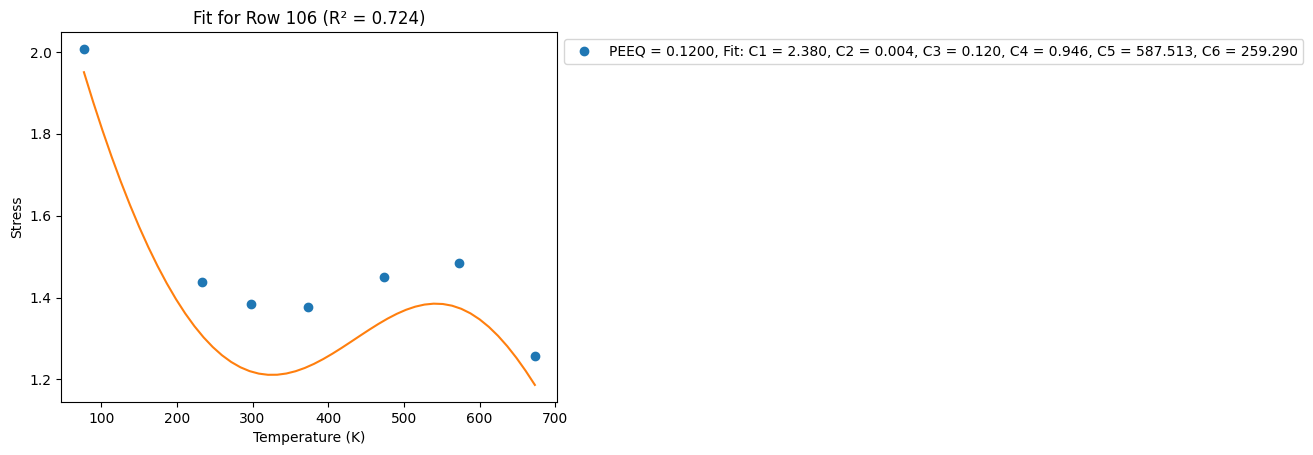

[2.05254389 1.44832038 1.39877799 1.39604457 1.4727197  1.51169222
 1.27465789]


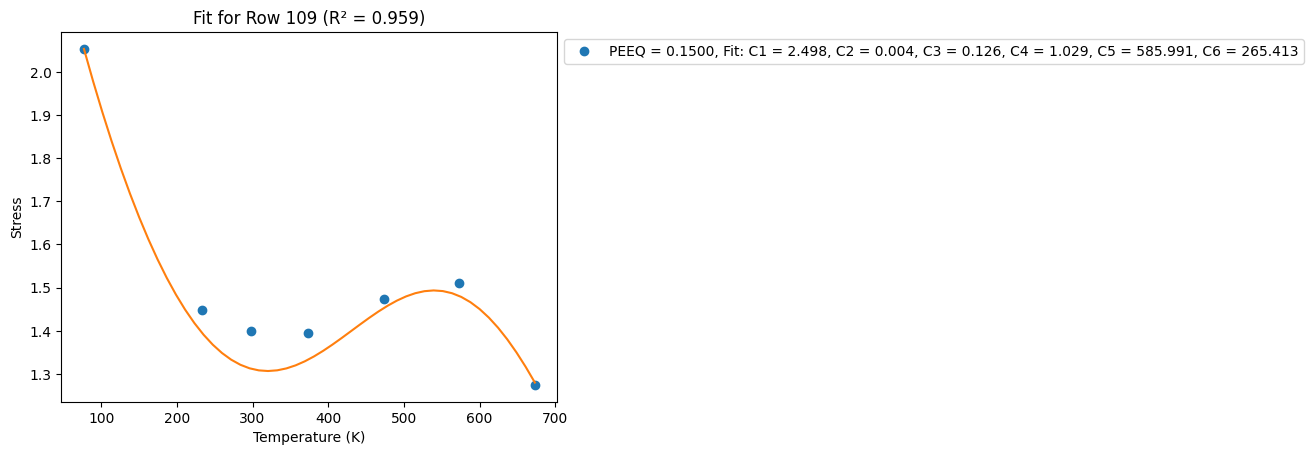

[2.09165822 1.45451203 1.41078586 1.41242702 1.49008186 1.53377461
 1.28963835]


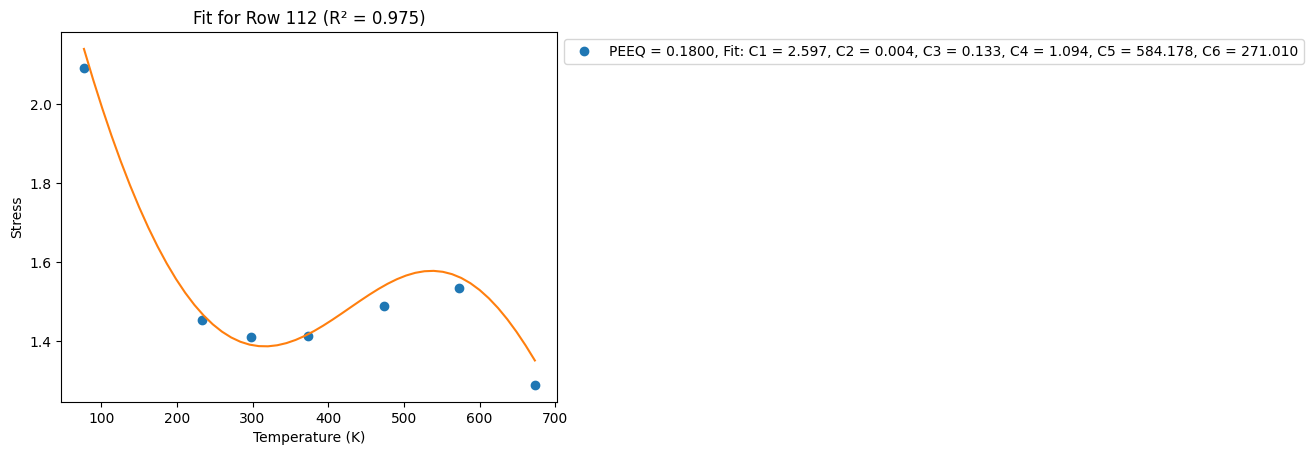

[2.12625012 1.4589786  1.42047422 1.42614474 1.50438693 1.55207615
 1.30217848]


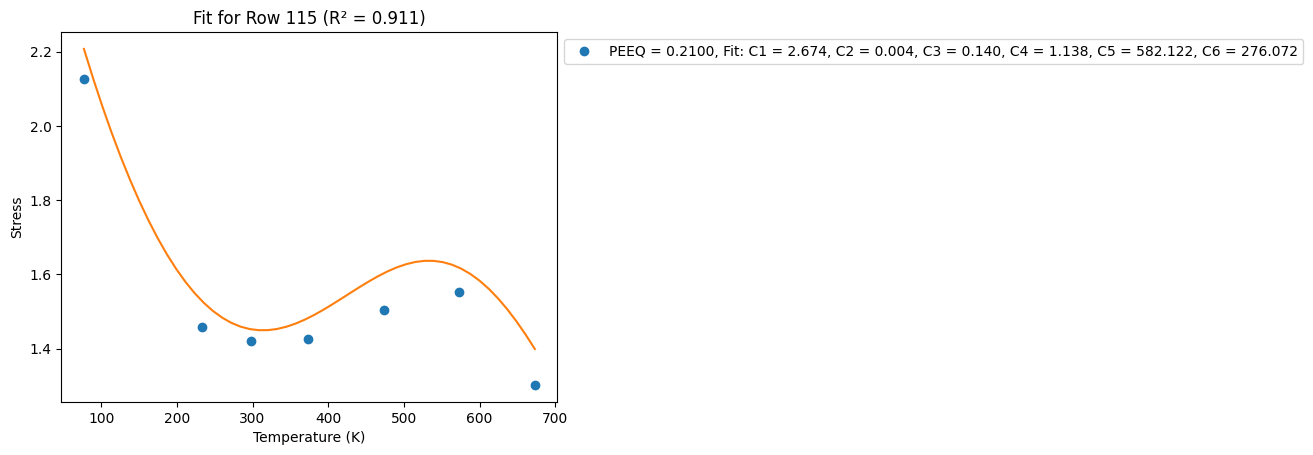

[2.15741767 1.46236236 1.42854963 1.43794489 1.51652335 1.56768197
 1.31296311]


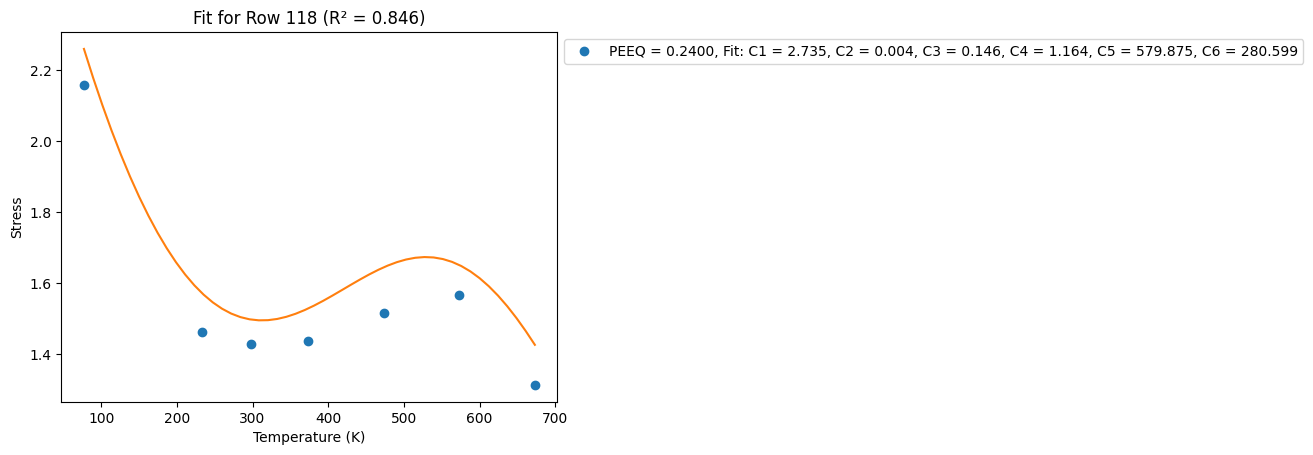

[2.18588733 1.4650201  1.43544364 1.44829864 1.52704423 1.58127062
 1.32242395]


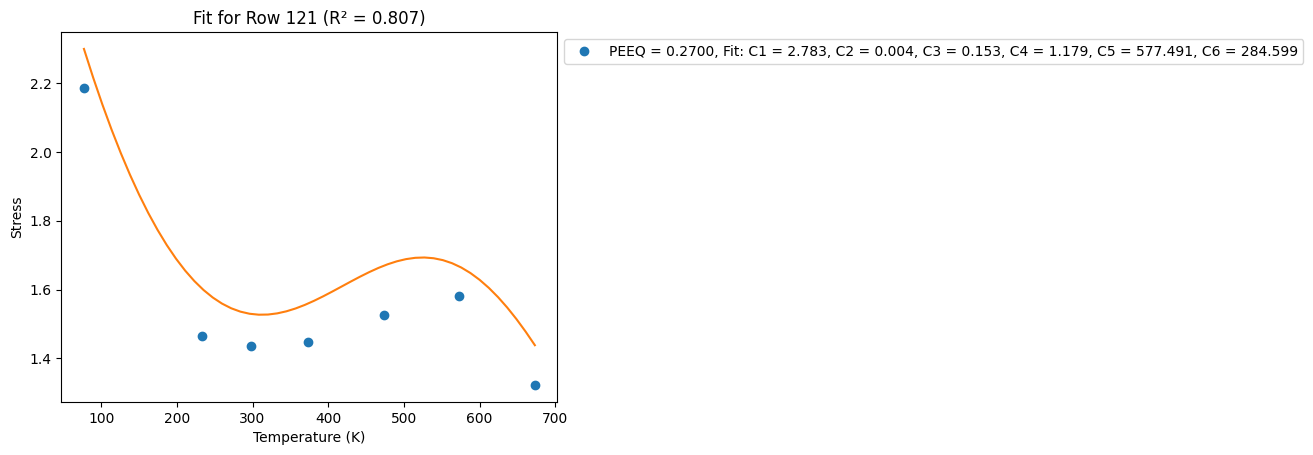

[2.21216737 1.46716637 1.44143808 1.45752234 1.53631672 1.59329433
 1.33085075]


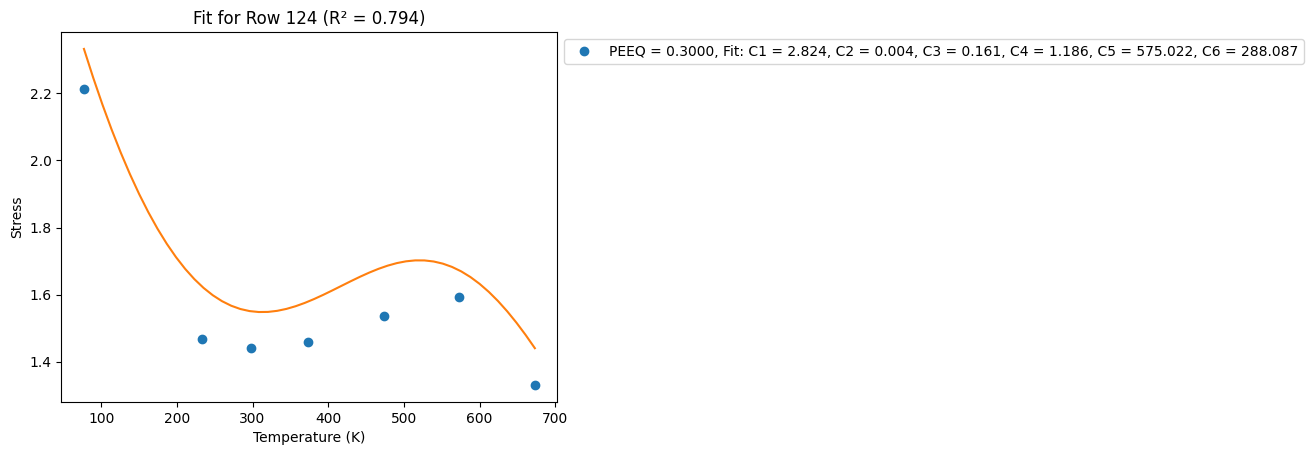

[2.23662885 1.46893819 1.44672661 1.46583868 1.54459672 1.6040694
 1.33844746]


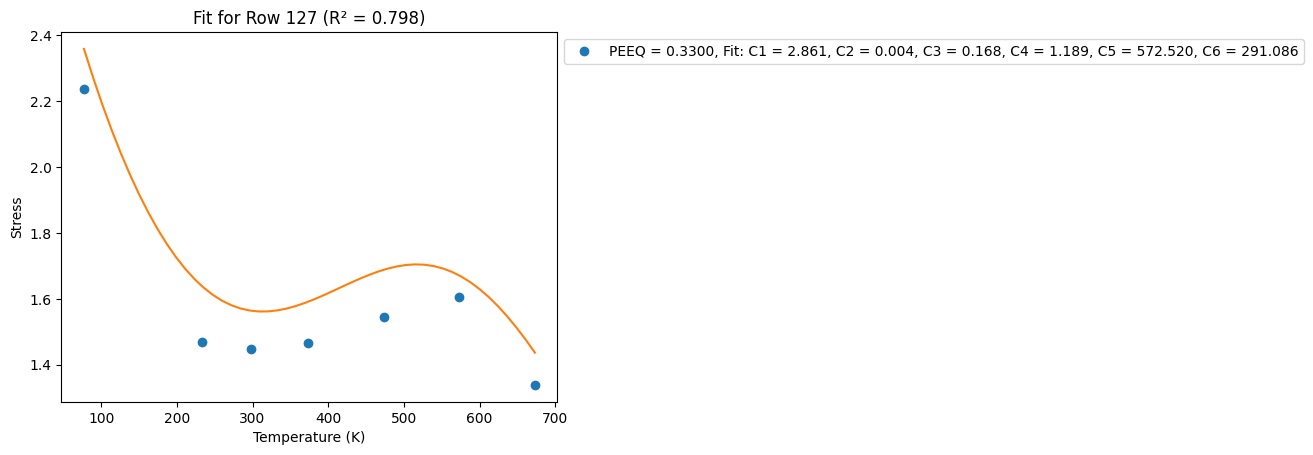

[2.25955177 1.47042731 1.45144765 1.47341038 1.55206946 1.61382558
 1.34536305]


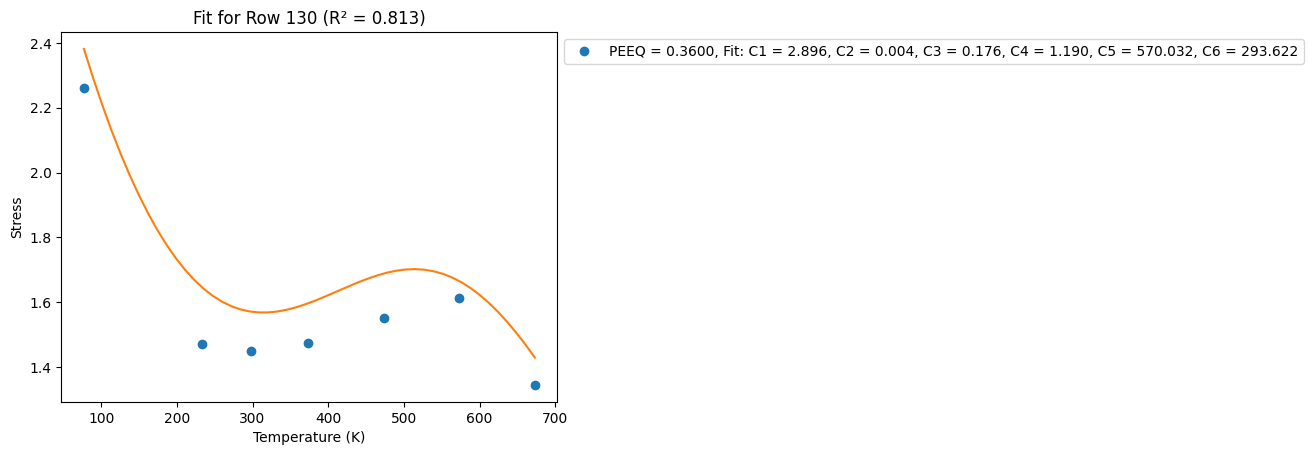

[2.28115324 1.47169753 1.45570342 1.48035998 1.55887328 1.62273494
 1.35170969]


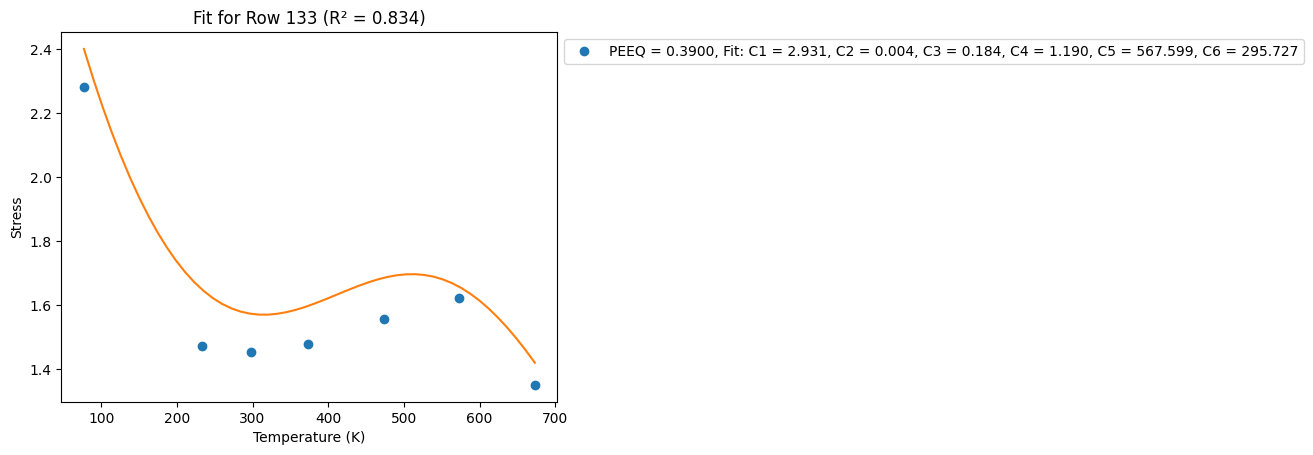

[2.30160534 1.47279466 1.45957138 1.48678203 1.56511412 1.63092962
 1.35757391]


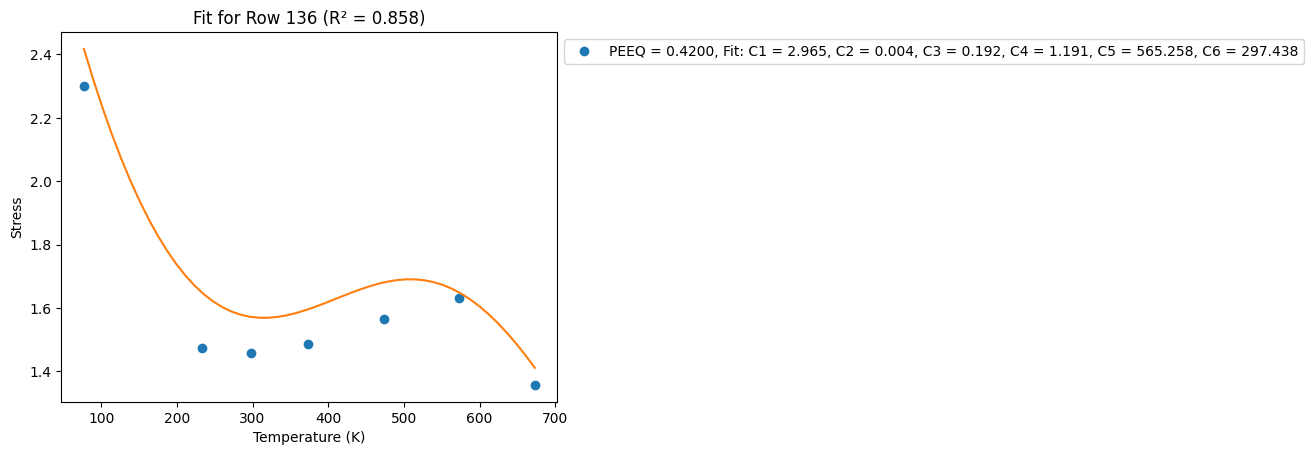

[2.32104702 1.47375244 1.46311158 1.49275104 1.57087488 1.63851328
 1.36302391]


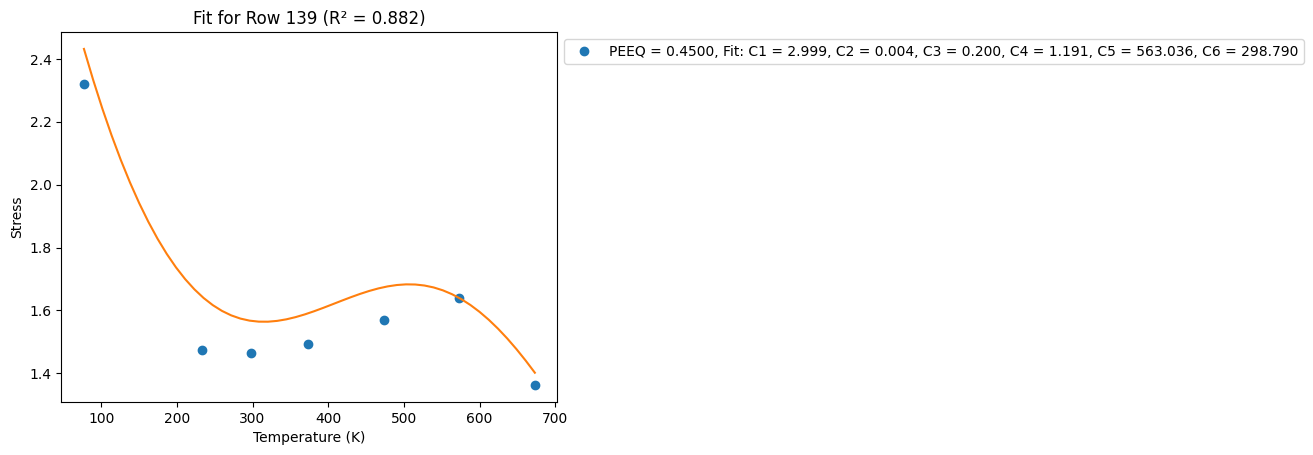

[2.33959227 1.47459633 1.46637144 1.49832679 1.57622159 1.64556872
 1.36811436]


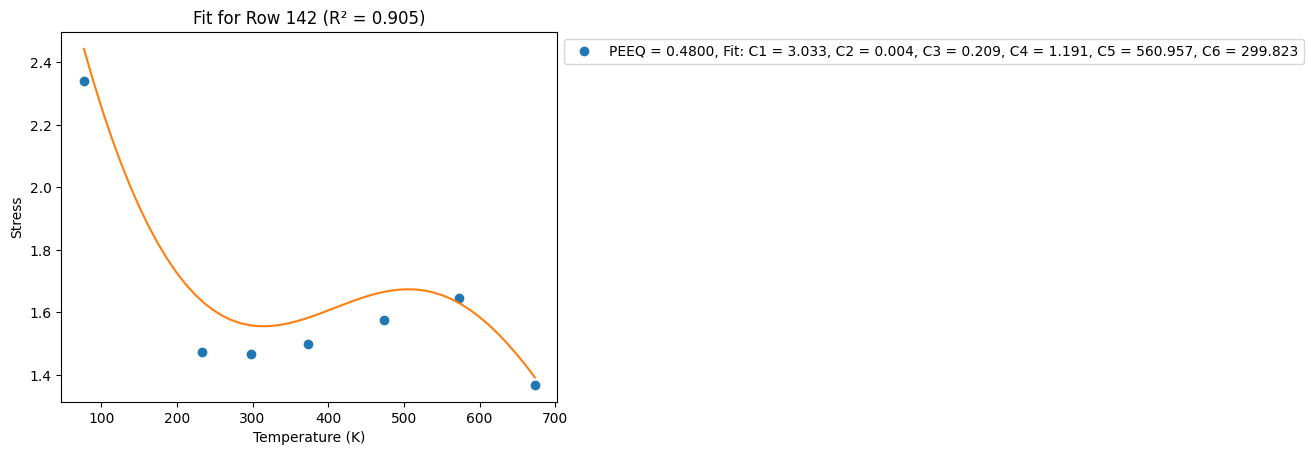

[2.35733591 1.47534587 1.46938903 1.50355792 1.58120769 1.65216307
 1.3728898 ]


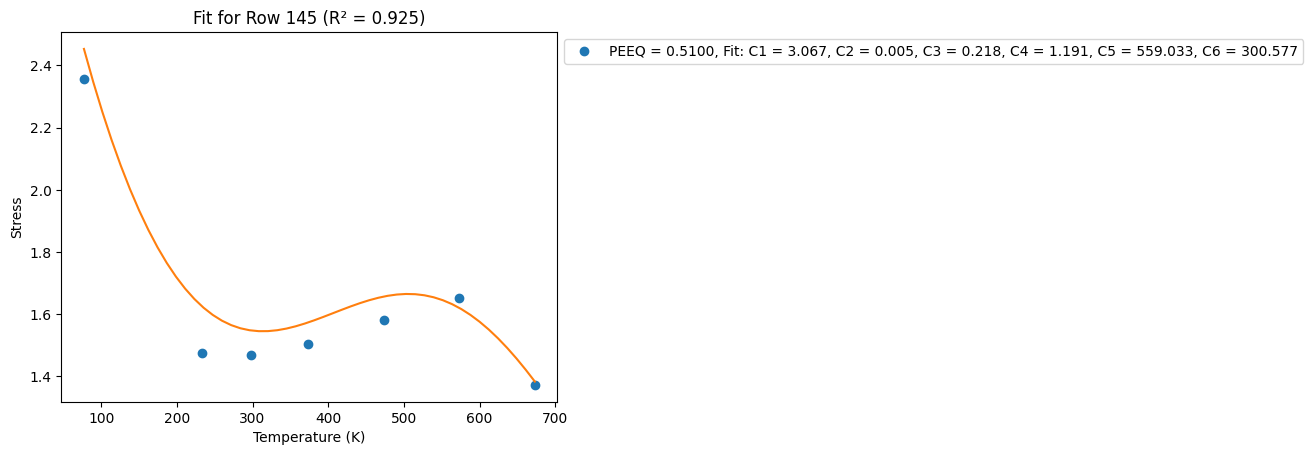

[2.37435771 1.47601635 1.47219533 1.5084846  1.58587703 1.65835153
 1.37738694]


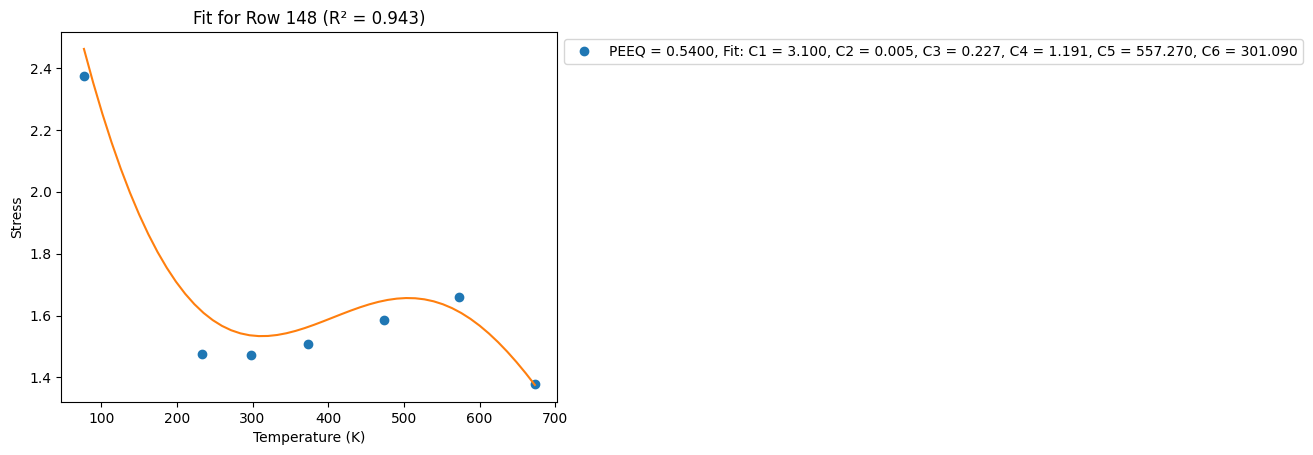

[2.39072553 1.47661989 1.47481589 1.51314033 1.590266   1.66418002
 1.38163644]


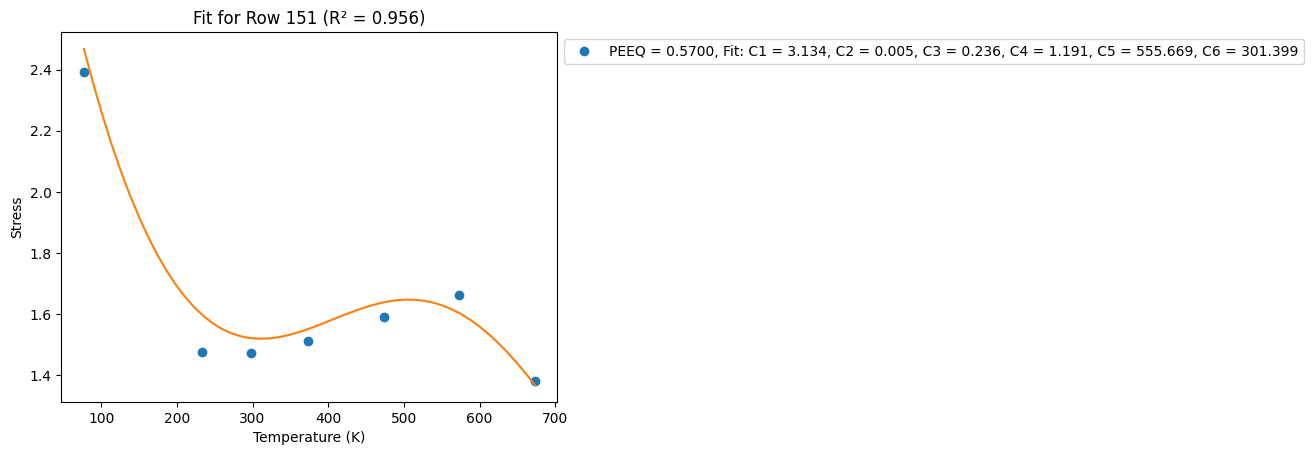

[2.40649759 1.47716622 1.47727202 1.5175534  1.59440515 1.66968715
 1.38566417]


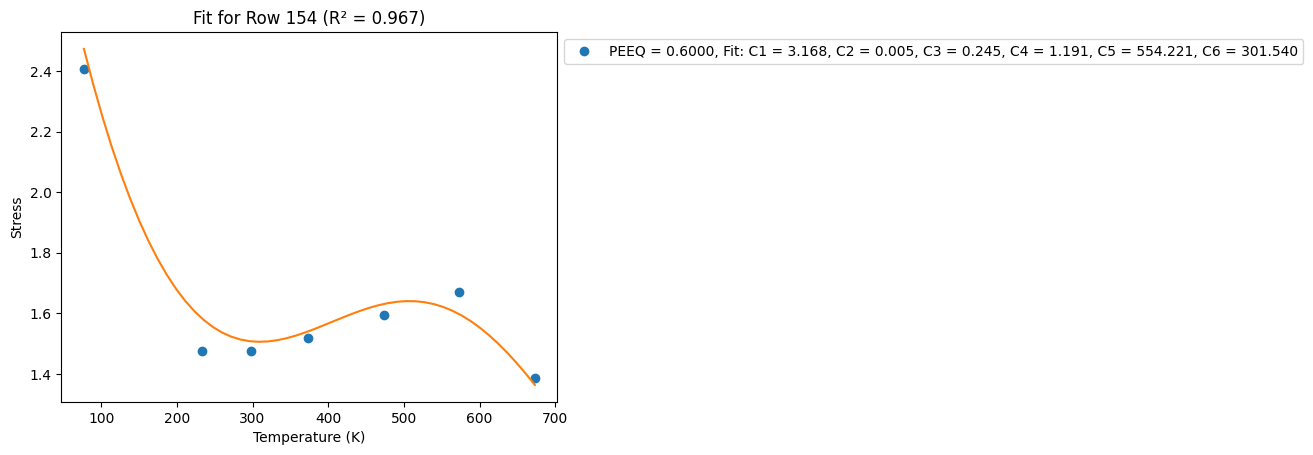

[2.42172429 1.47766327 1.47958161 1.52174786 1.59832033 1.67490566
 1.38949212]


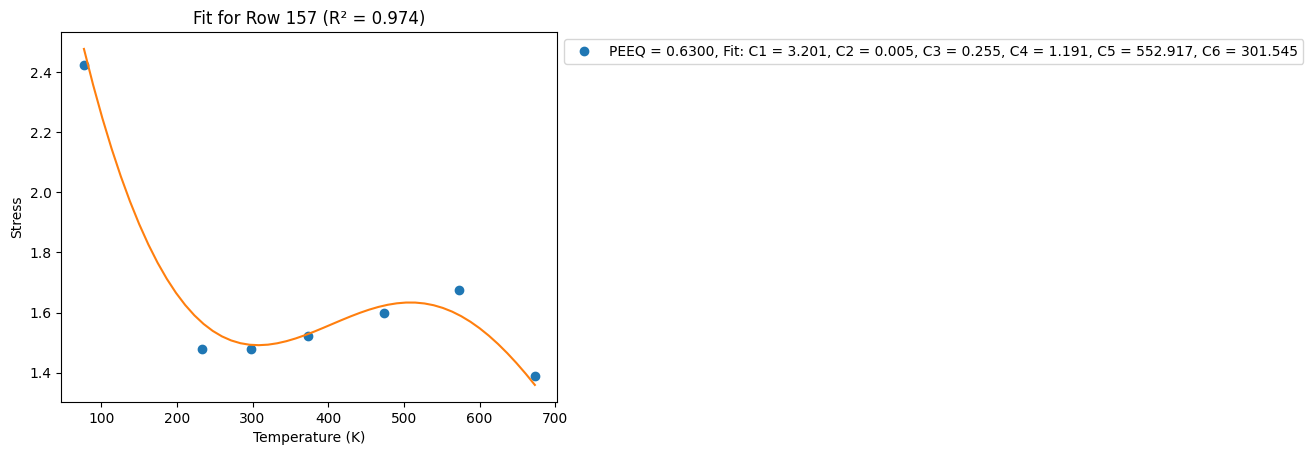

[2.43644957 1.47811755 1.4817599  1.52574436 1.60203365 1.67986358
 1.39313919]


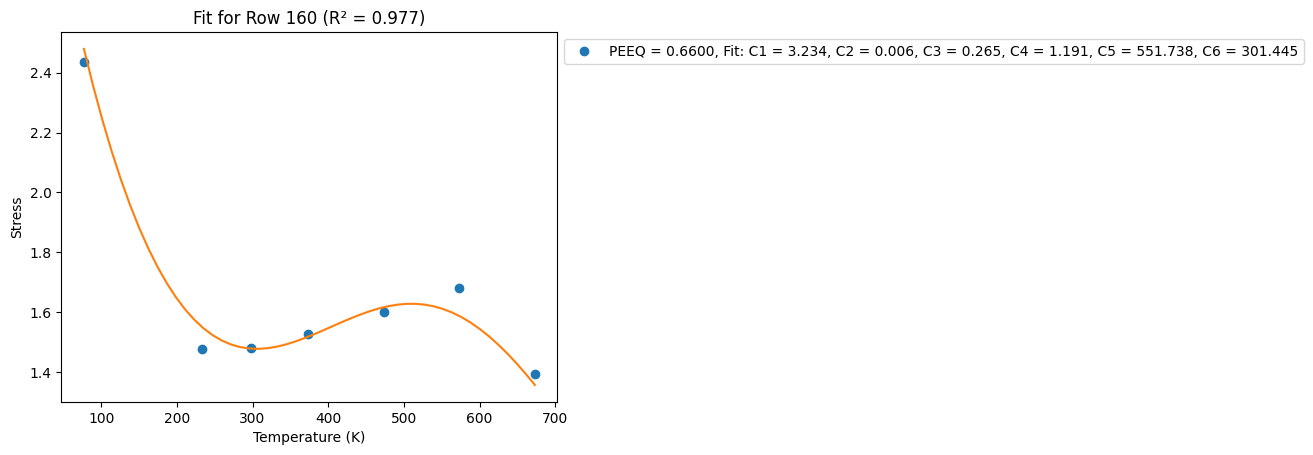

[2.45071197 1.47853446 1.48381991 1.52956076 1.60556412 1.68458509
 1.3966217 ]


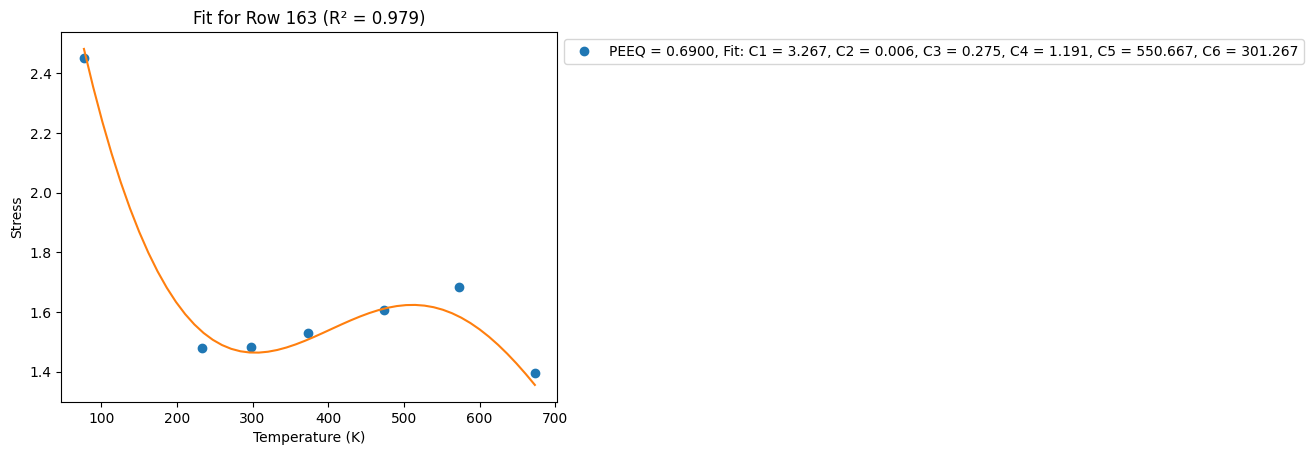

[2.46454554 1.47891853 1.48577287 1.53321261 1.60892823 1.68909115
 1.39995386]


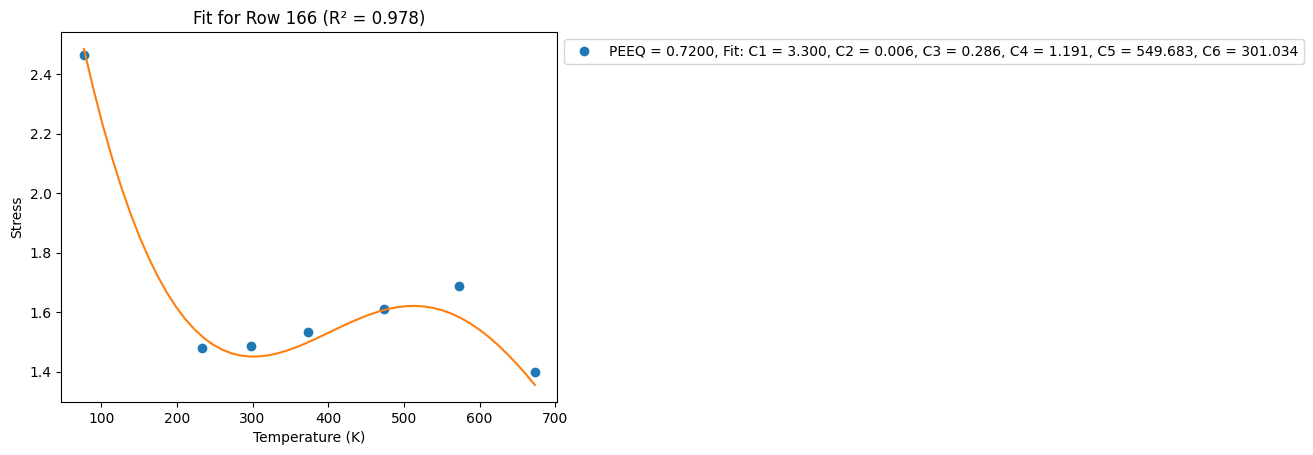

[2.4779805  1.47927356 1.48762852 1.53671352 1.61214036 1.6934001
 1.40314812]


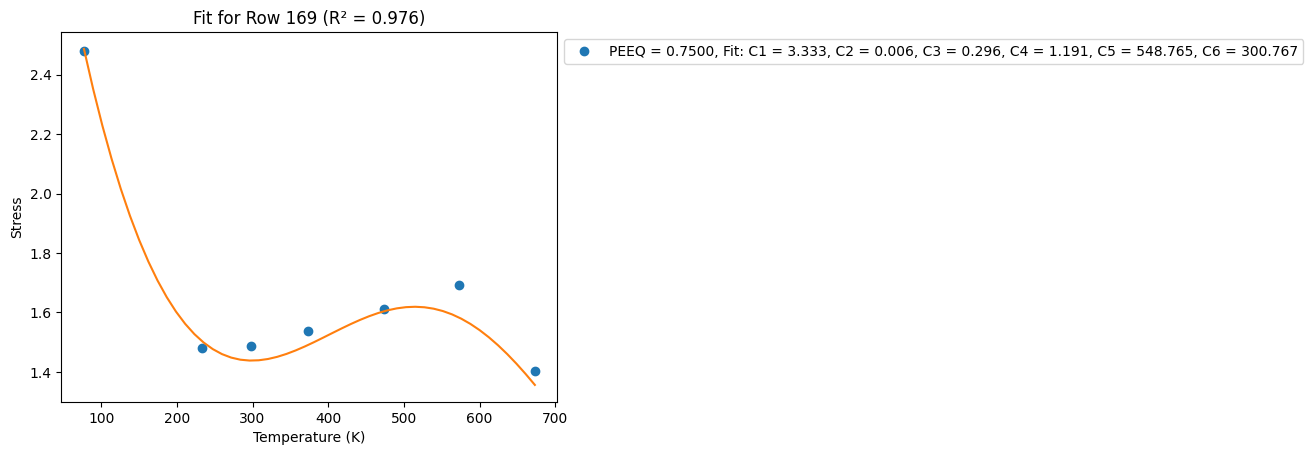

[2.49104383 1.4796028  1.48939536 1.54007547 1.61521313 1.69752803
 1.40621544]


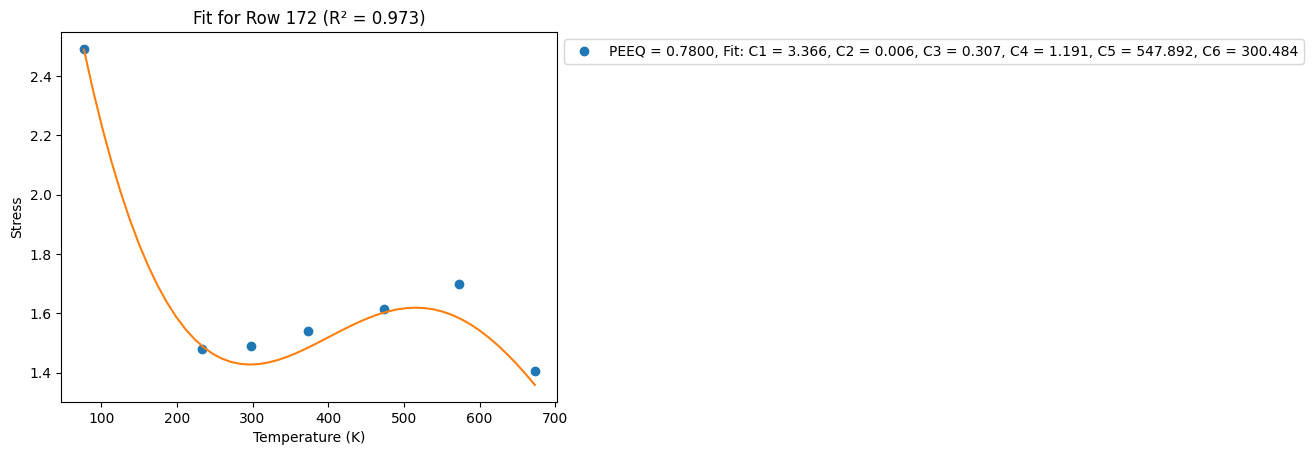

[2.50375969 1.47990901 1.49108087 1.54330909 1.61815766 1.70148918
 1.40916553]


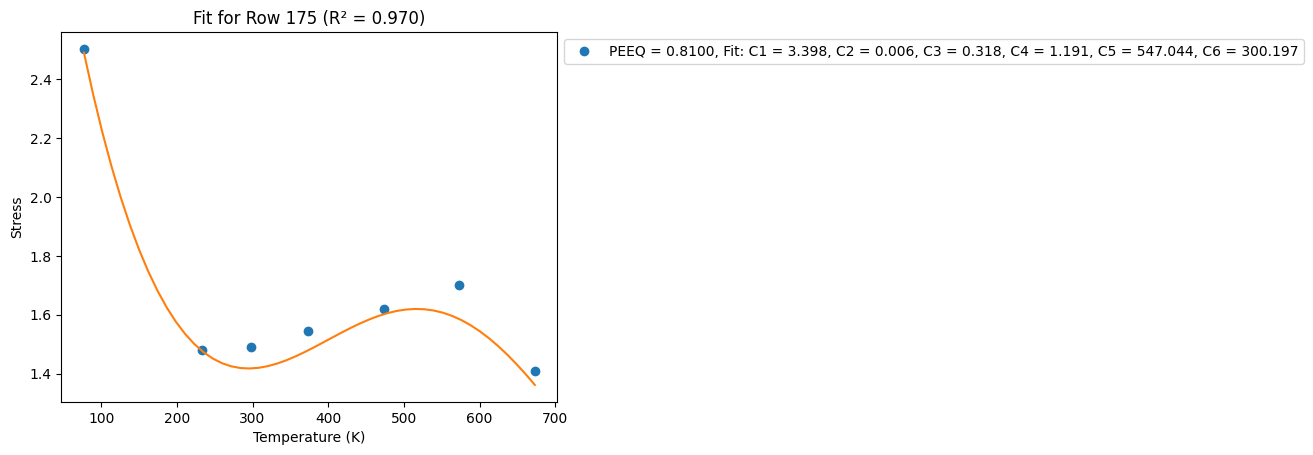

[2.51614987 1.48019458 1.49269163 1.54642382 1.62098383 1.70529616
 1.41200702]


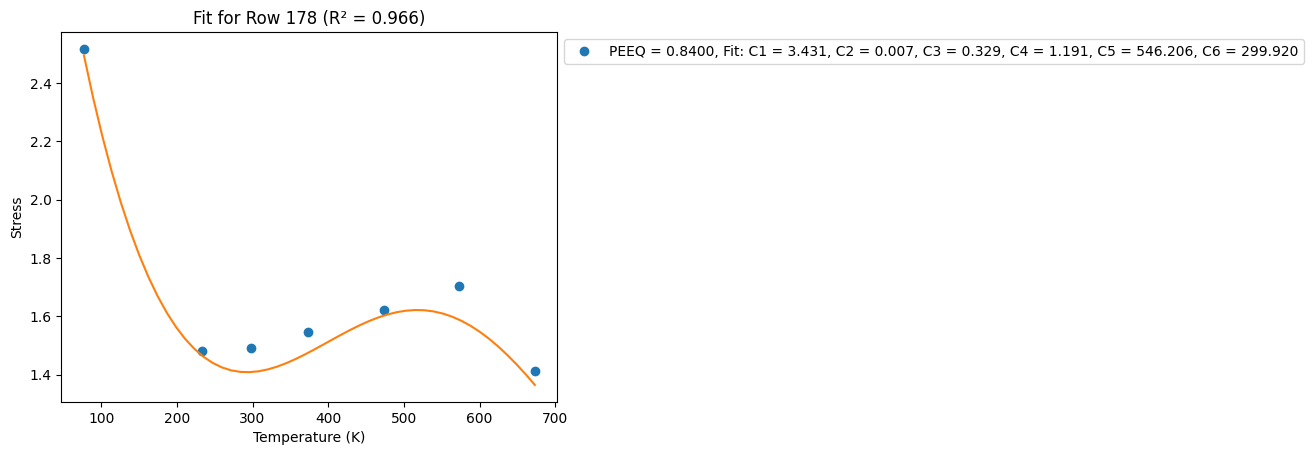

[2.52823403 1.48046156 1.49423348 1.5494281  1.6237004  1.70896023
 1.41474763]


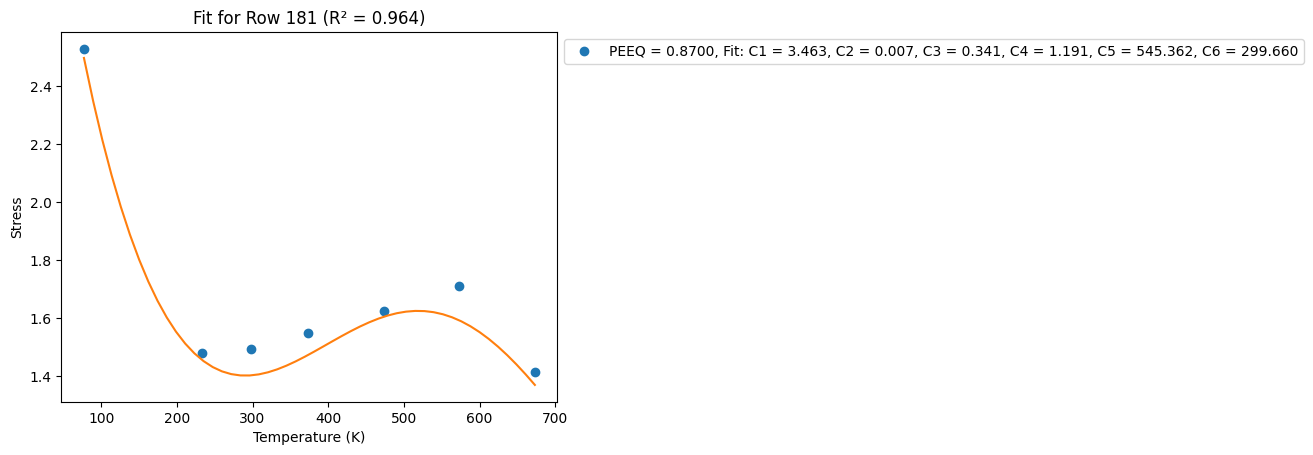

[2.54003003 1.48071176 1.49571163 1.5523295  1.62631523 1.71249146
 1.41739426]


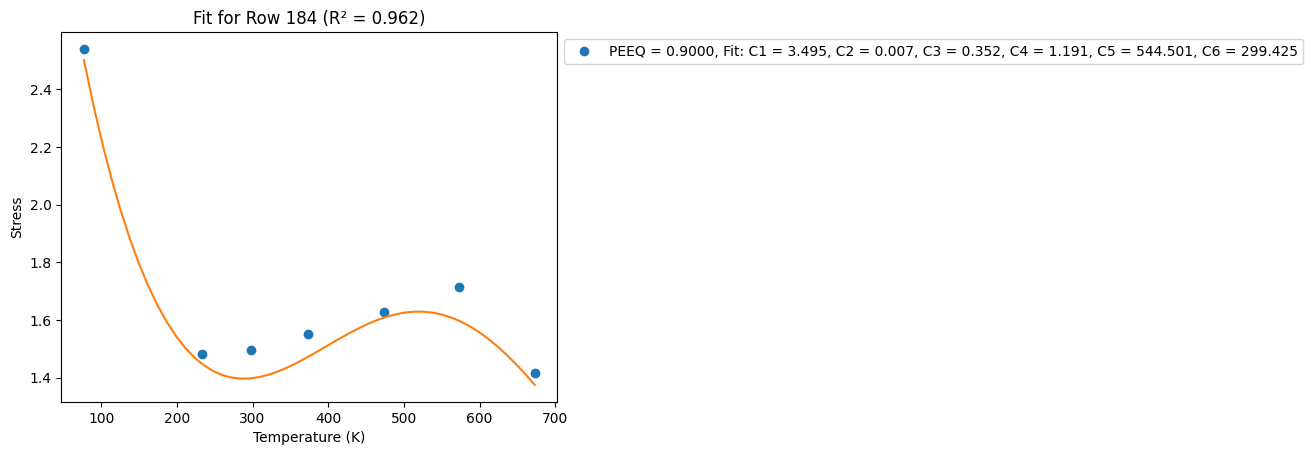

[2.5515541  1.48094675 1.49713073 1.55513484 1.62883538 1.71589891
 1.41995316]


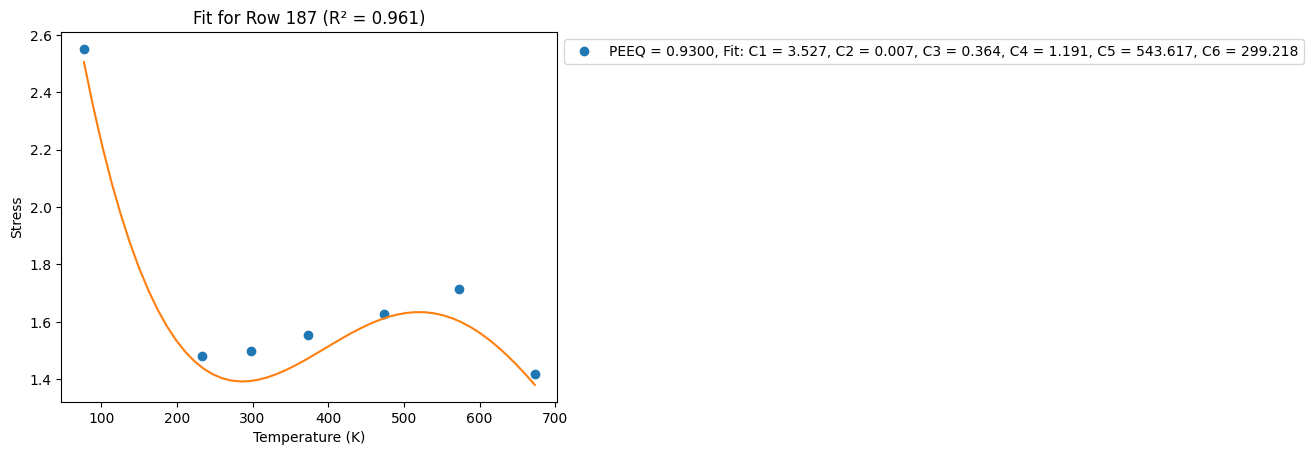

[2.56282109 1.48116788 1.49849493 1.55785027 1.63126719 1.71919075
 1.42242996]


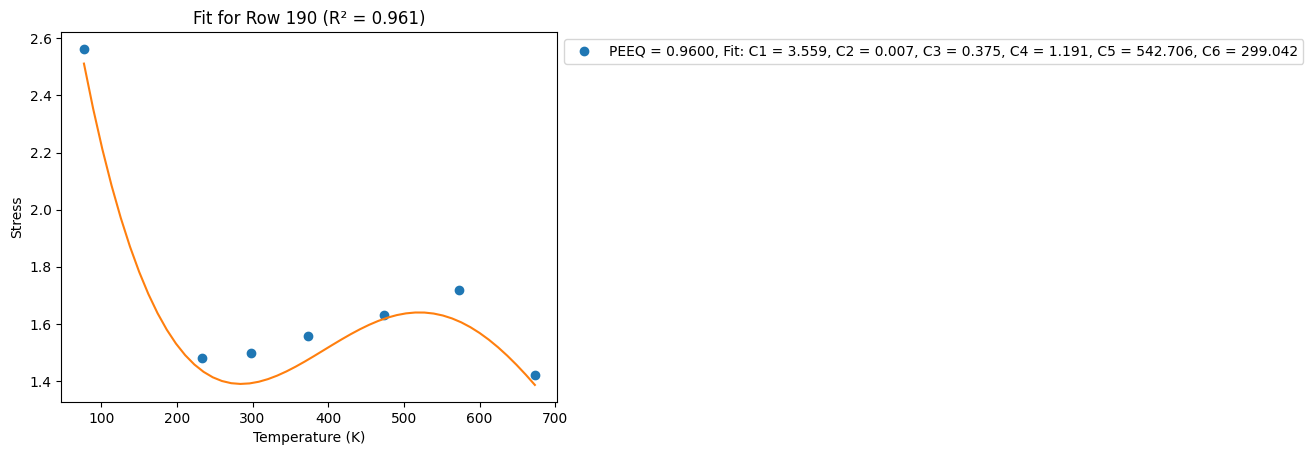

[2.57384459 1.4813764  1.49980801 1.56048139 1.63361641 1.72237436
 1.42482975]


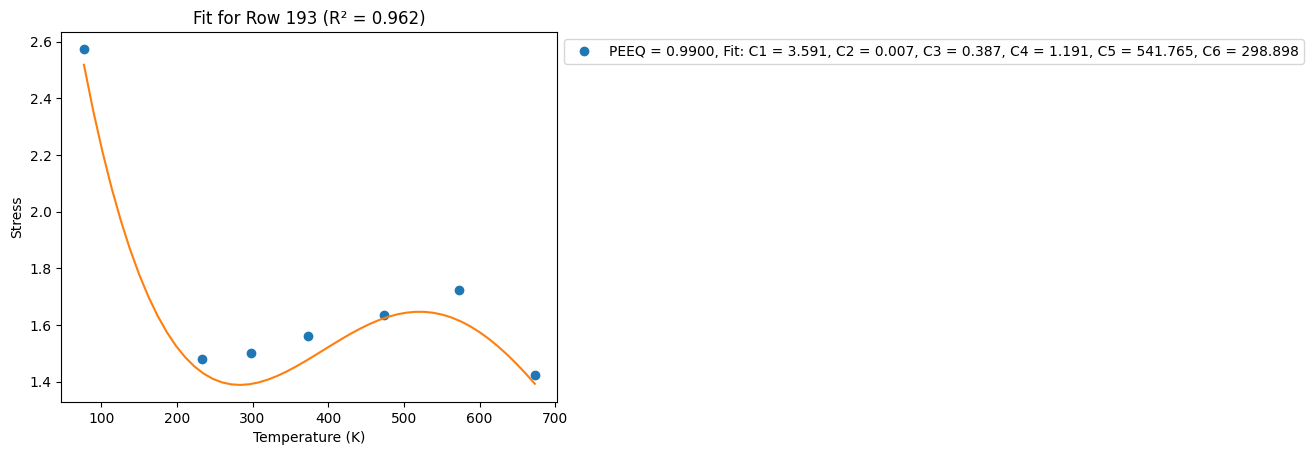

[2.58463707 1.48157335 1.50107336 1.56303328 1.63588823 1.72545646
 1.42715719]


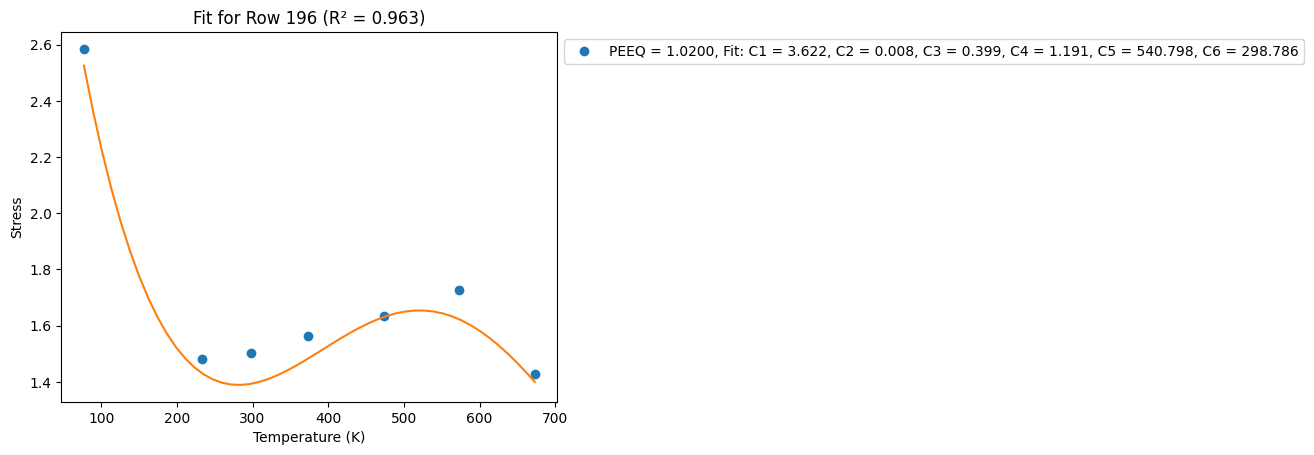

[2.59521003 1.48175971 1.50229406 1.56551056 1.6380874  1.72844315
 1.42941651]


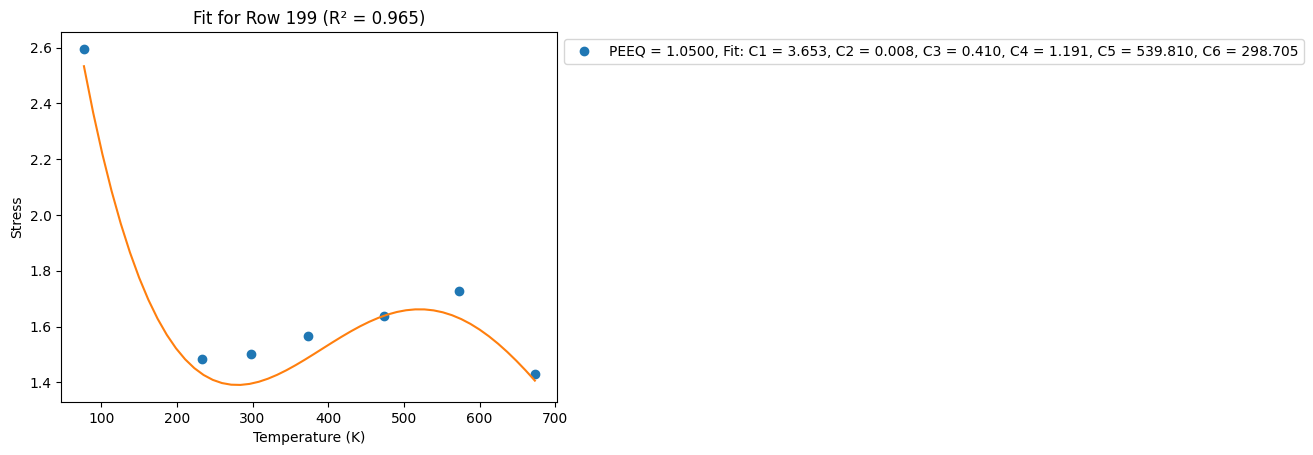

[2.60557407 1.48193632 1.50347289 1.56791749 1.64021823 1.73134002
 1.43161158]


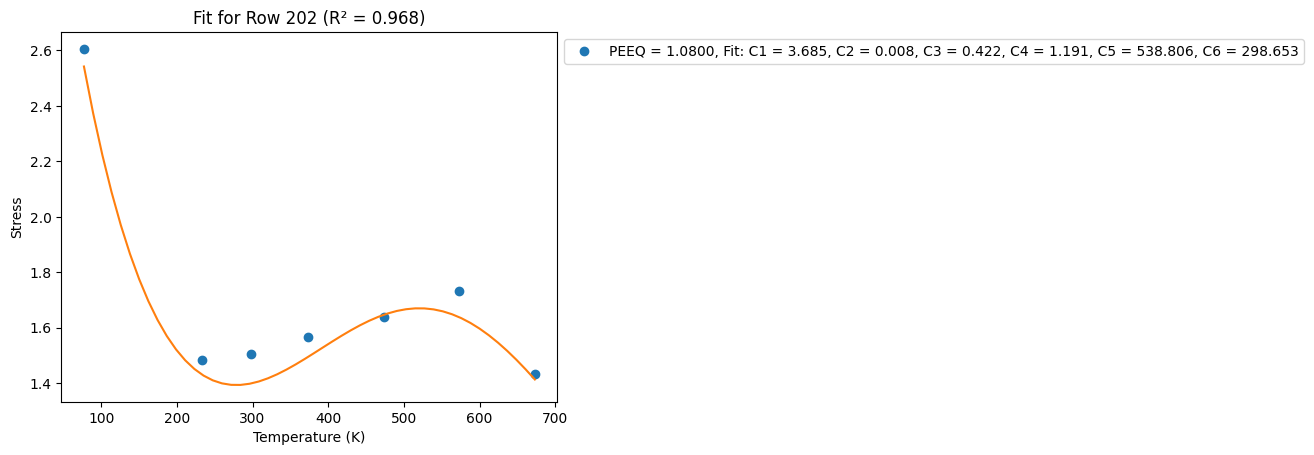

[2.61573902 1.48210394 1.50461241 1.57025796 1.64228468 1.73415217
 1.43374596]


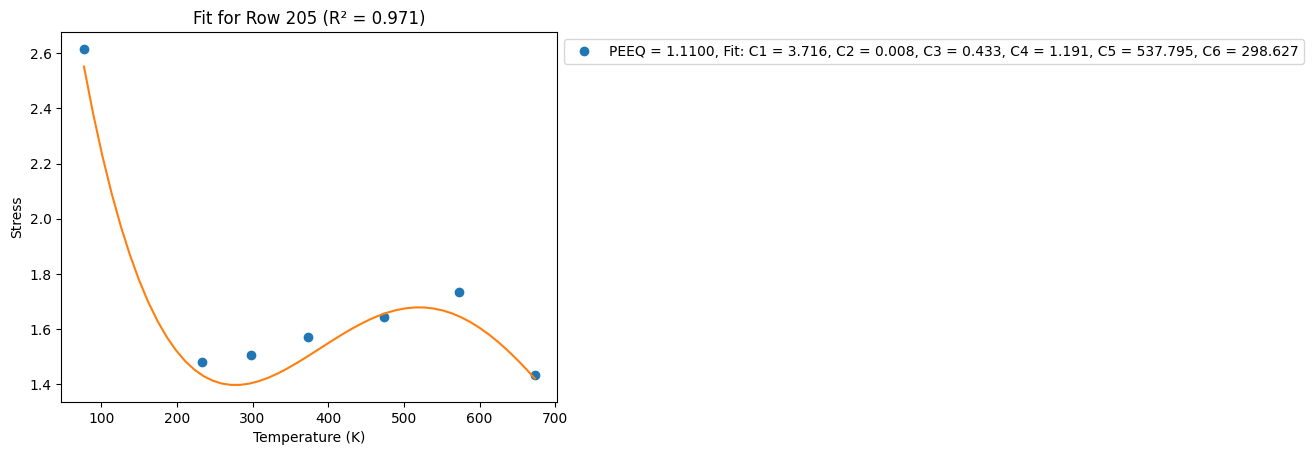

[2.62571398 1.48226326 1.50571496 1.57253553 1.64429036 1.73688429
 1.43582292]


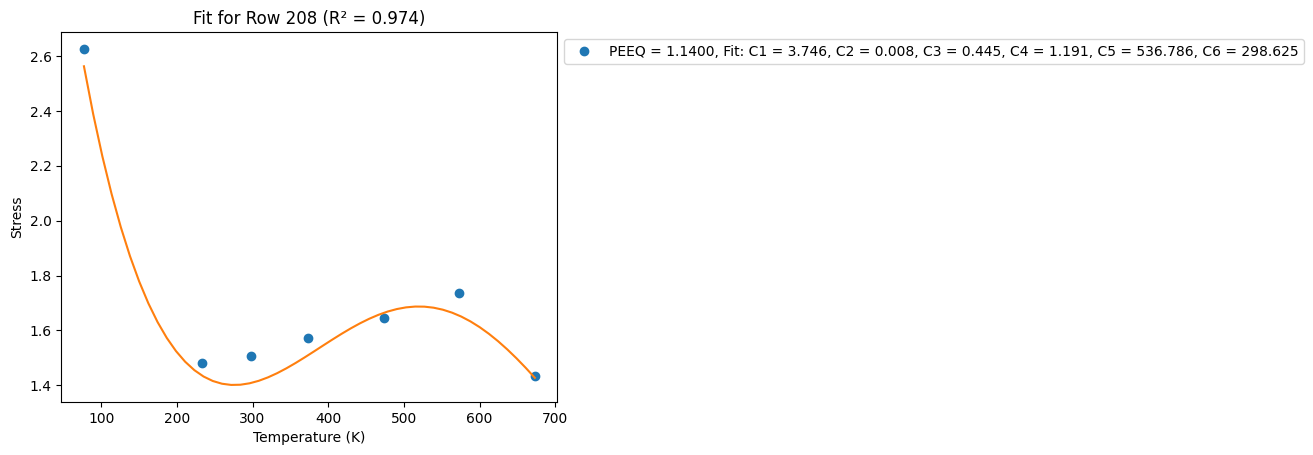

[2.63550739 1.48241489 1.50678266 1.5747535  1.64623861 1.7395407
 1.43784546]


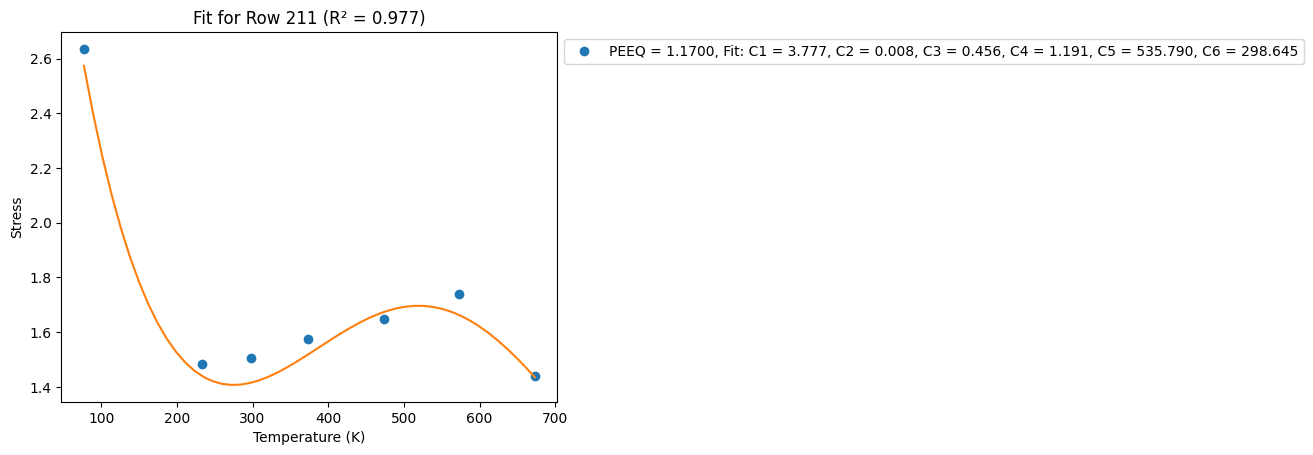

[2.64512714 1.48255939 1.50781748 1.57691491 1.64813249 1.74212537
 1.43981636]


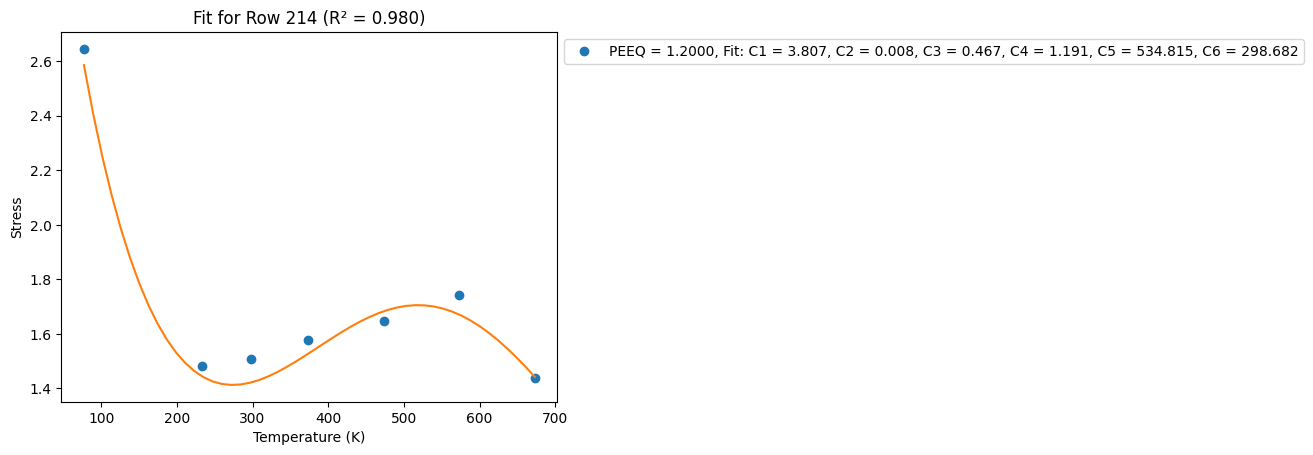

[2.65458057 1.48269725 1.50882122 1.57902257 1.64997484 1.74464197
 1.44173819]


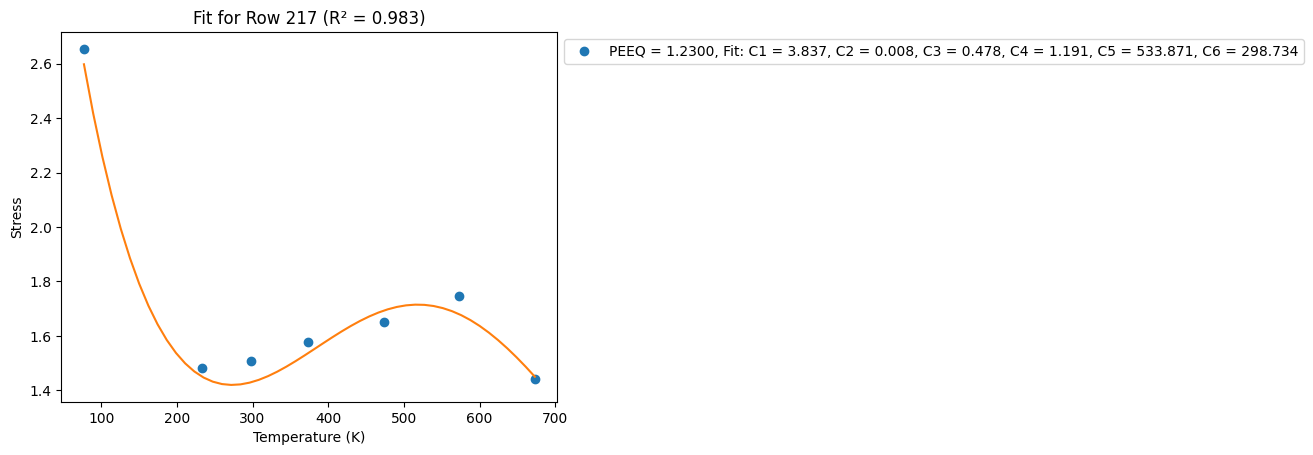

[2.66387453 1.48282895 1.50979554 1.58107911 1.65176827 1.74709391
 1.44361335]


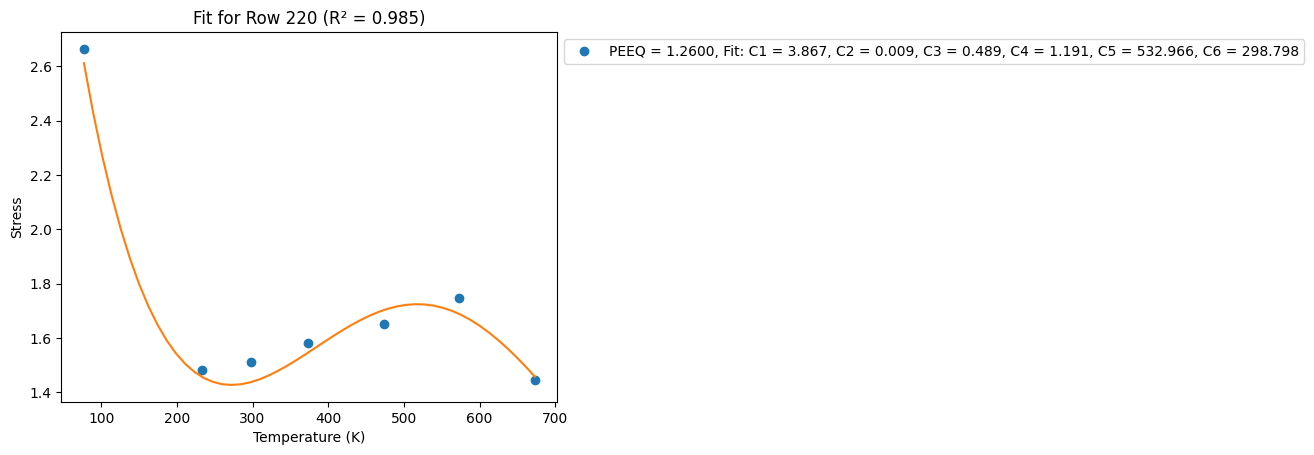

[2.67301546 1.48295488 1.51074198 1.58308693 1.6535152  1.74948434
 1.44544403]


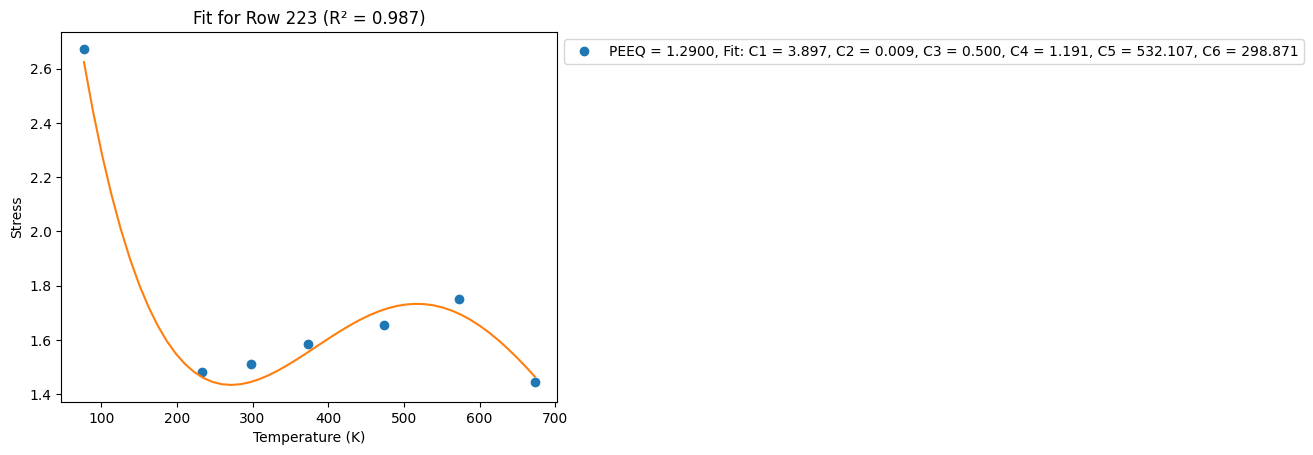

[2.68200936 1.48307543 1.51166196 1.5850483  1.65521789 1.75181618
 1.44723231]


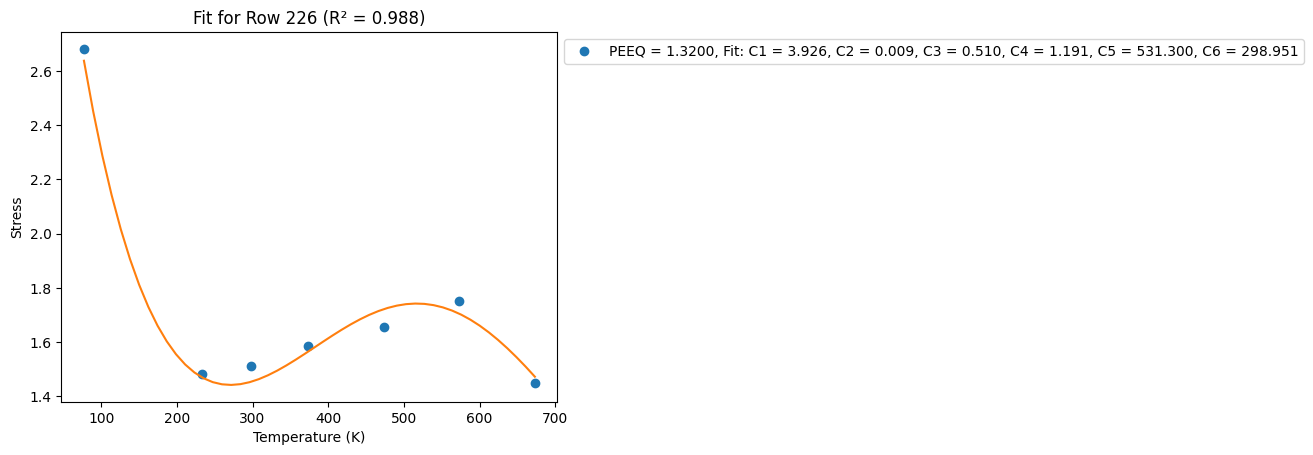

[2.6908619  1.48319095 1.51255681 1.58696532 1.65687844 1.75409218
 1.4489801 ]


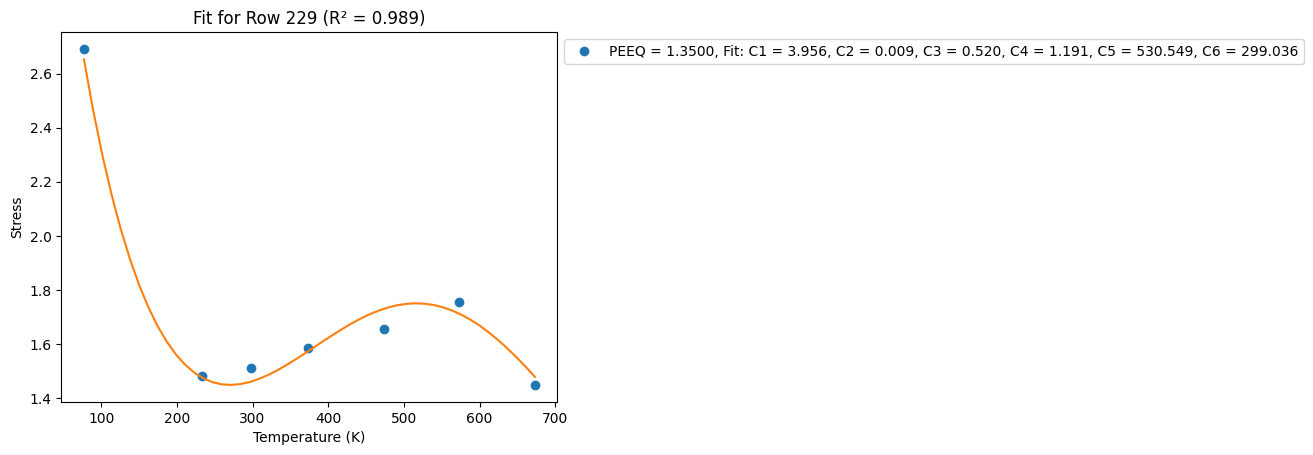

[2.69957839 1.48330174 1.51342775 1.58883995 1.6584988  1.75631486
 1.4506892 ]


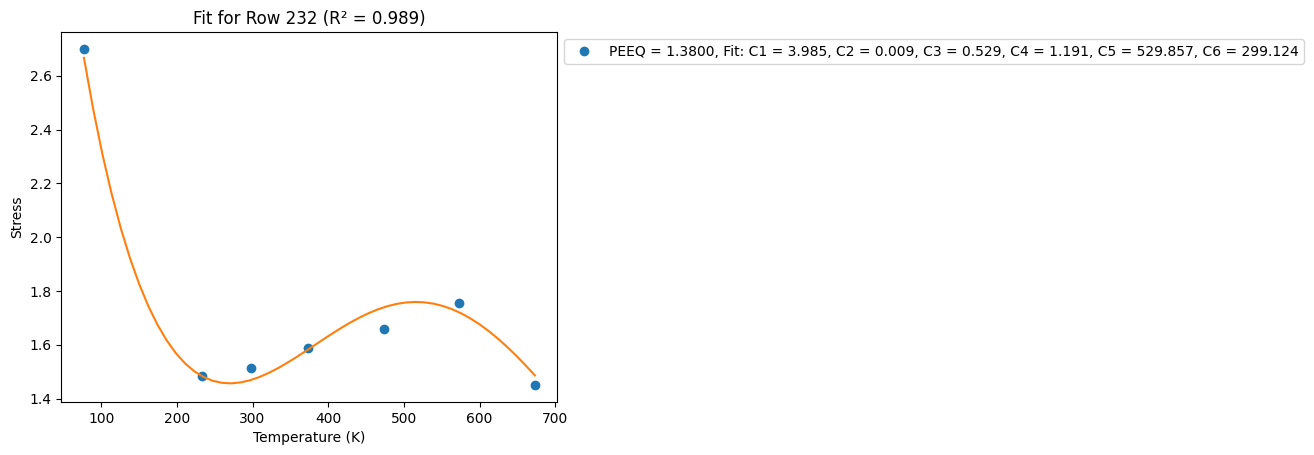

[2.70816383 1.48340811 1.51427593 1.59067402 1.66008078 1.75848662
 1.45236128]


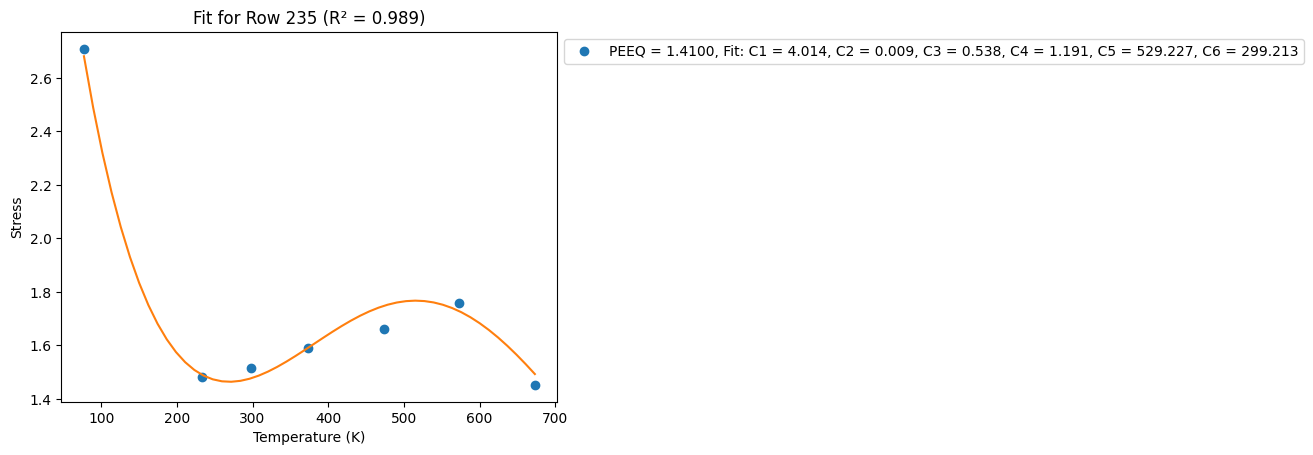

[2.71662293 1.48351031 1.5151024  1.59246926 1.66162609 1.76060966
 1.45399791]


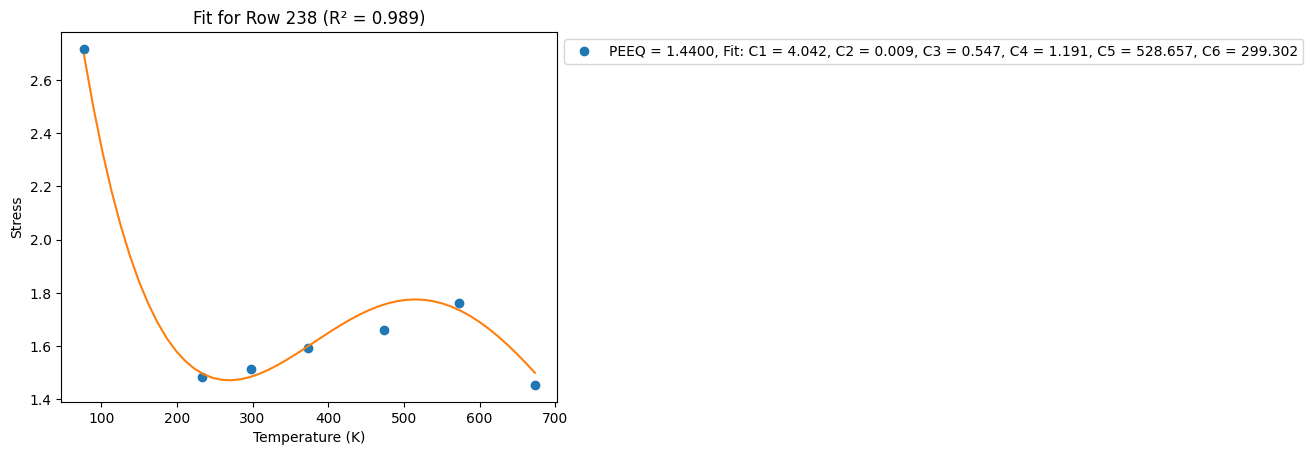

[2.72496014 1.48360859 1.51590816 1.59422728 1.66313633 1.76268607
 1.45560057]


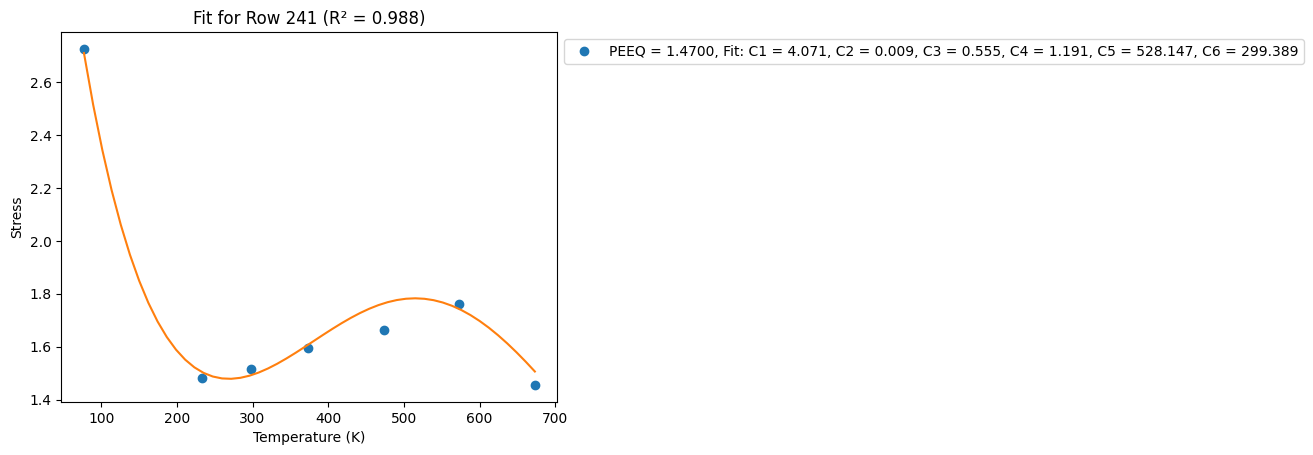

[2.73317969 1.48370317 1.51669414 1.59594958 1.66461297 1.7647178
 1.45717063]


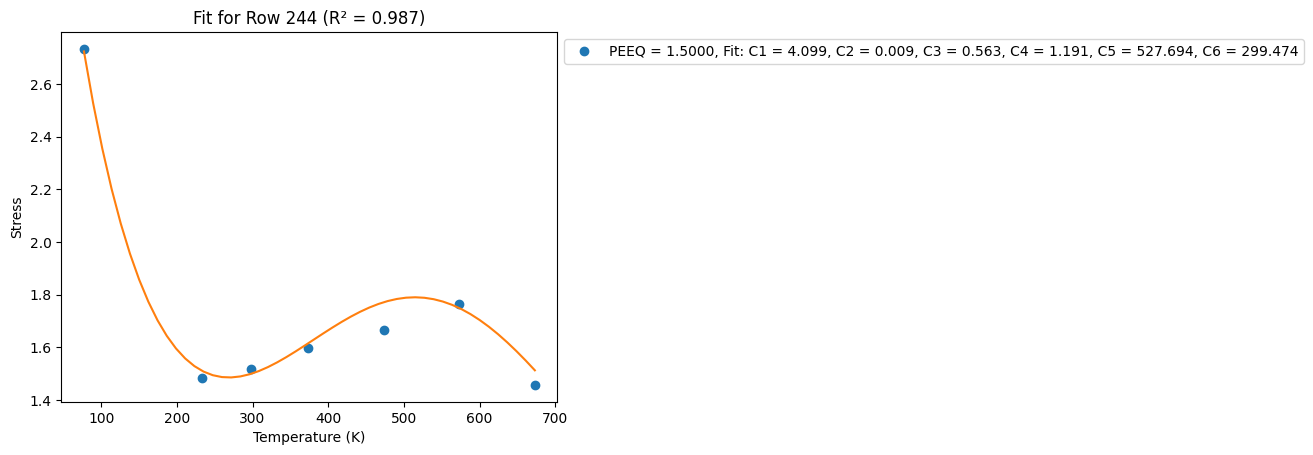

[2.74128553 1.48379428 1.51746121 1.5976376  1.66605744 1.76670669
 1.45870939]


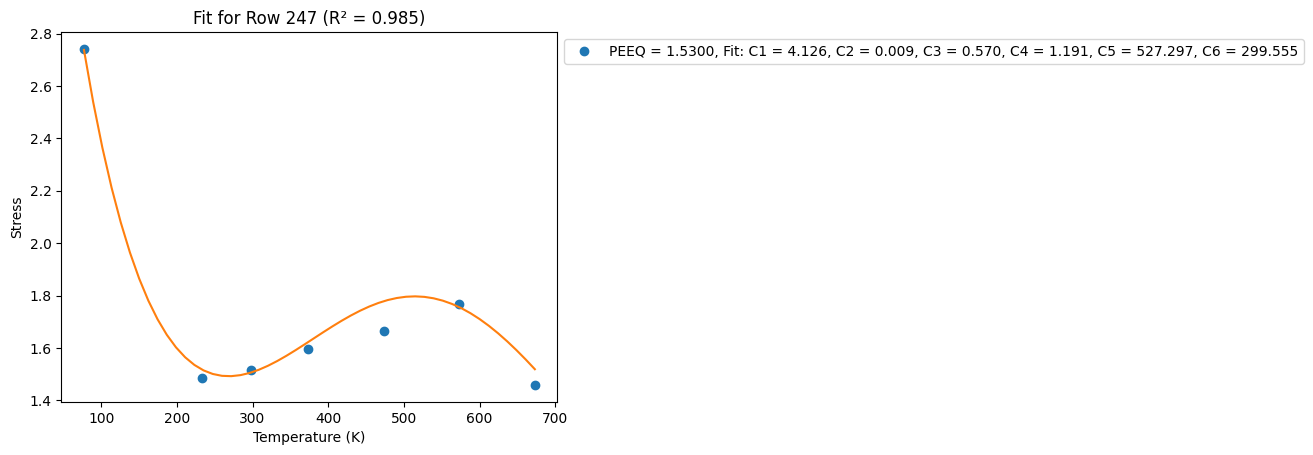

[2.74928146 1.48388209 1.51821018 1.59929267 1.66747103 1.76865445
 1.46021809]


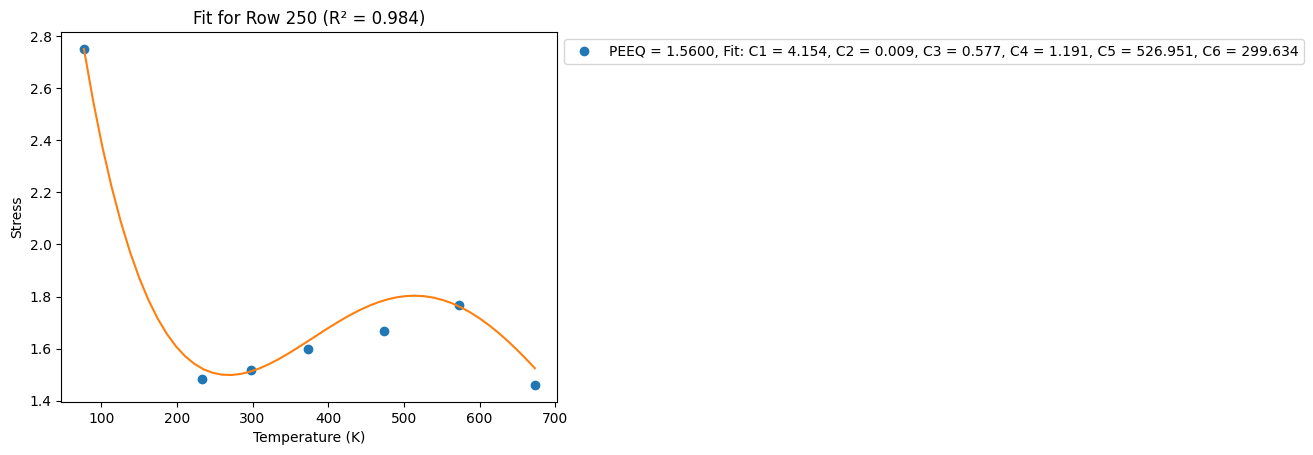

[2.75717103 1.48396679 1.51894182 1.60091605 1.668855   1.7705627
 1.46169787]


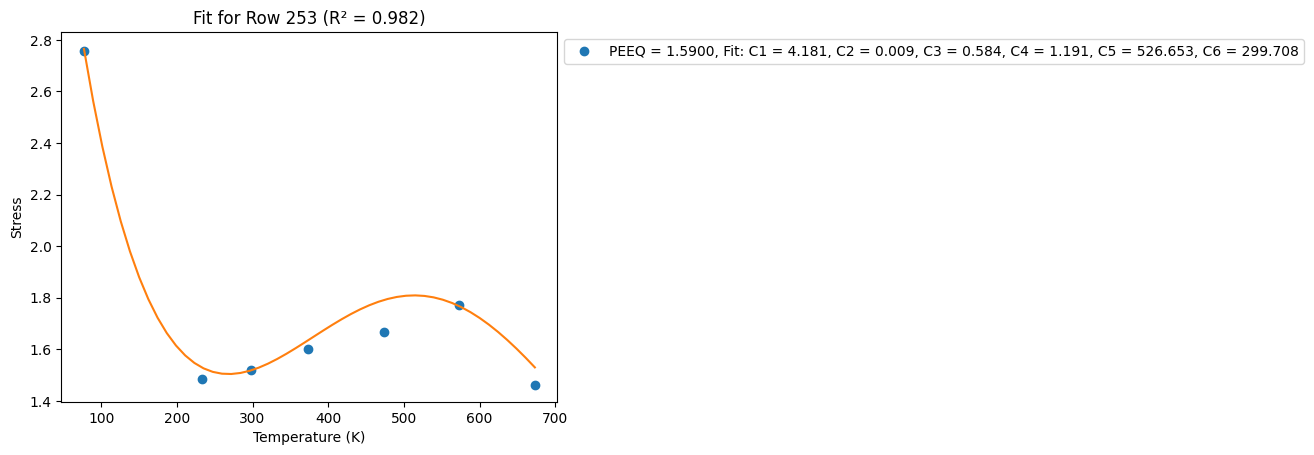

[2.76495765 1.48404854 1.51965684 1.60250894 1.6702105  1.77243298
 1.46314981]


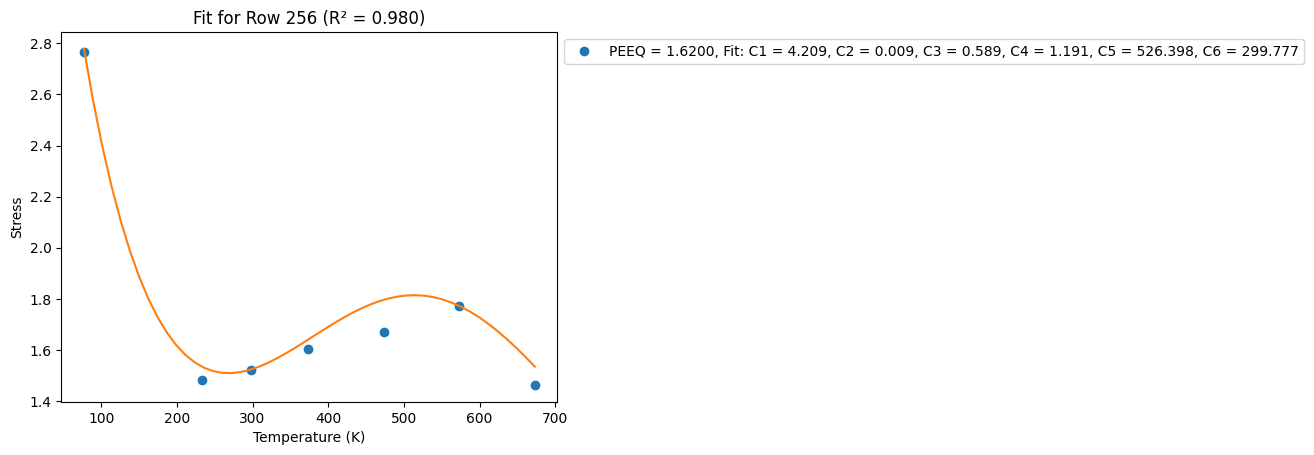

[2.77264454 1.48412751 1.52035593 1.60407246 1.67153863 1.77426673
 1.46457496]


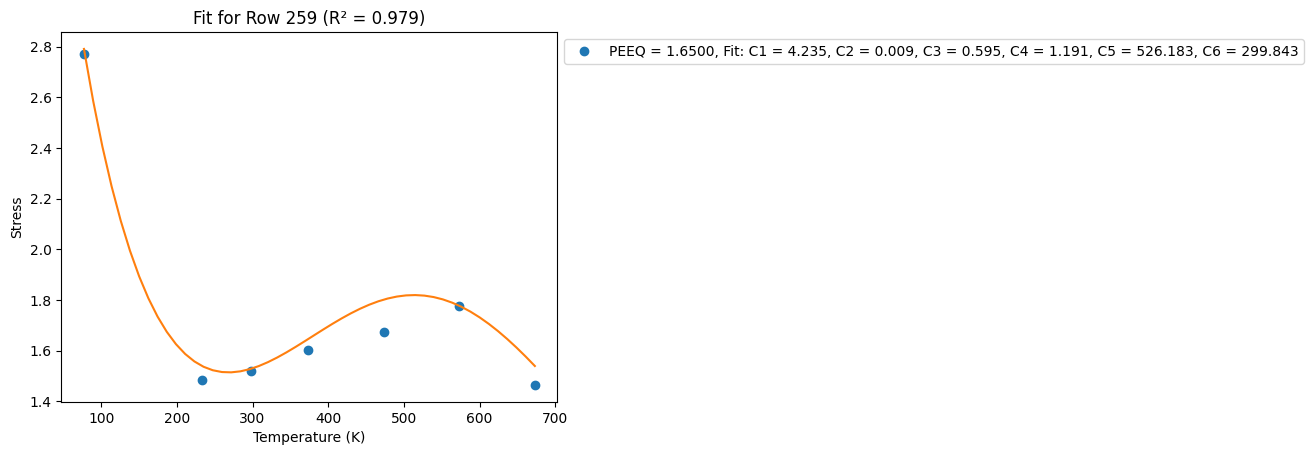

[2.78023477 1.48420382 1.52103972 1.60560768 1.67284043 1.77606531
 1.46597427]


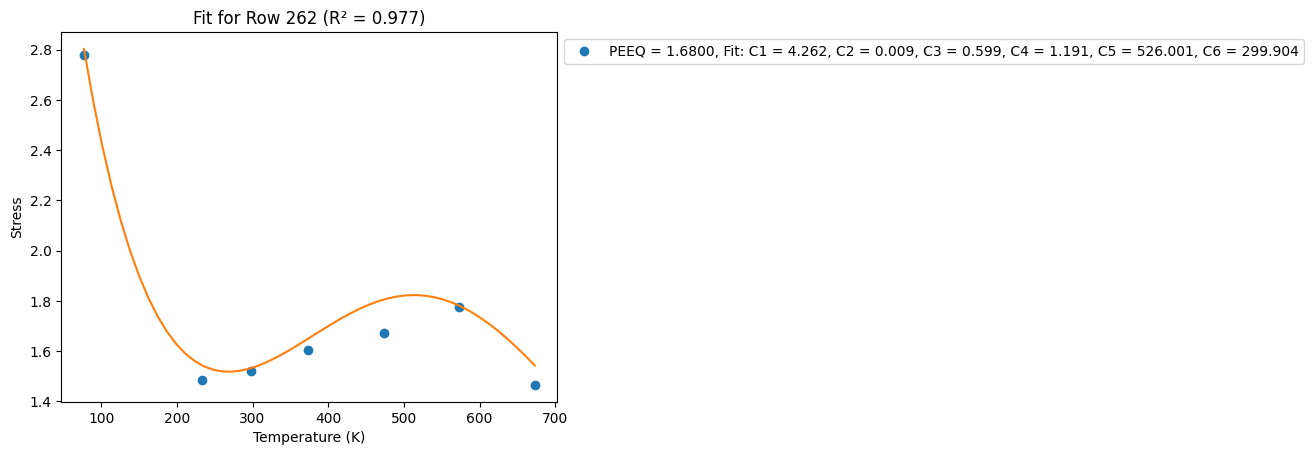

[2.78773126 1.48427762 1.52170881 1.60711559 1.67411689 1.77783001
 1.46734867]


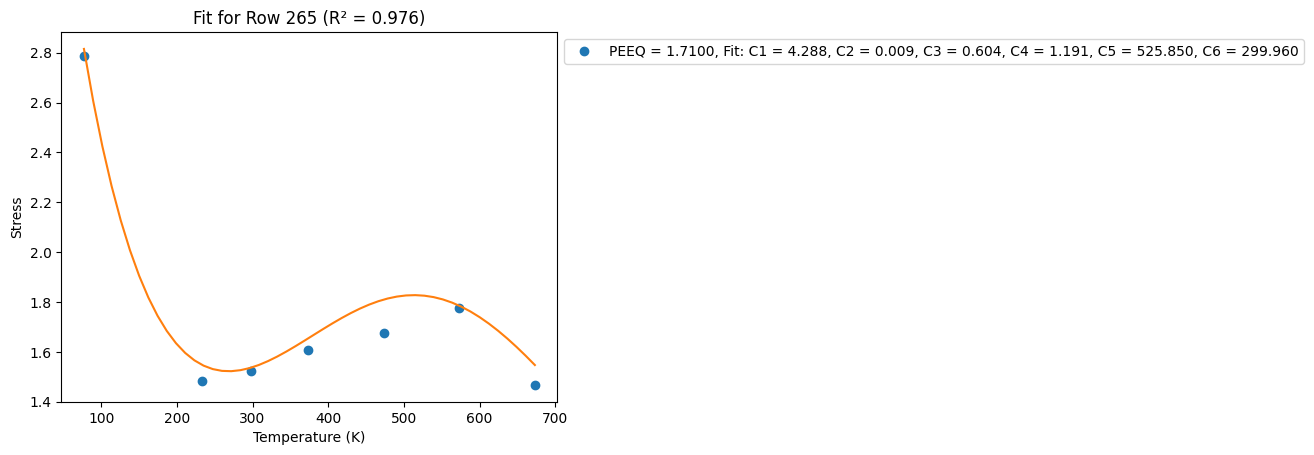

[2.79513678 1.48434904 1.52236377 1.60859716 1.67536893 1.77956204
 1.46869903]


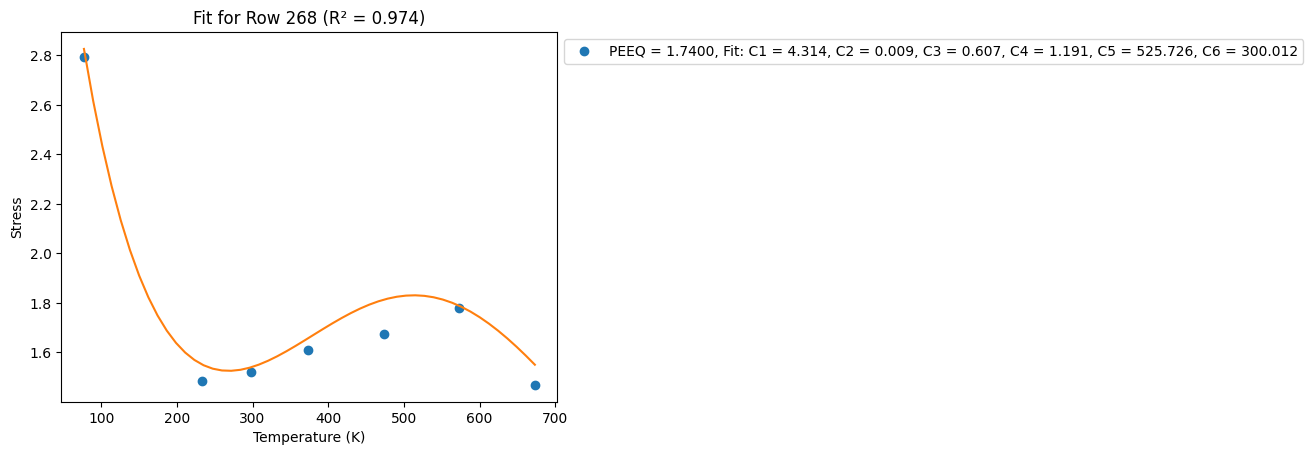

[2.802454   1.48441818 1.52300514 1.6100533  1.67659743 1.78126257
 1.47002618]


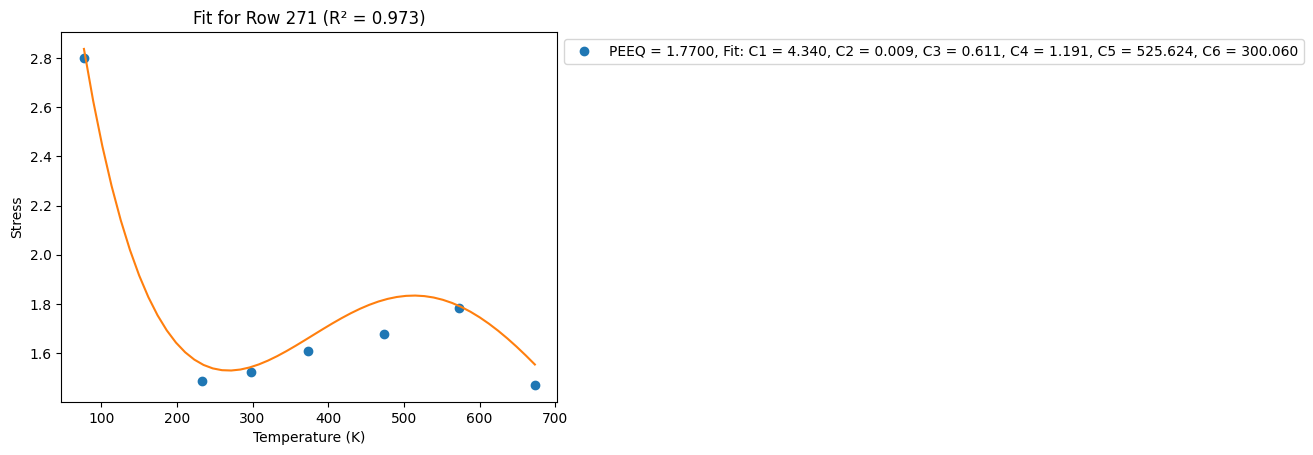

[2.80968544 1.48448516 1.52363341 1.61148485 1.67780322 1.78293269
 1.4713309 ]


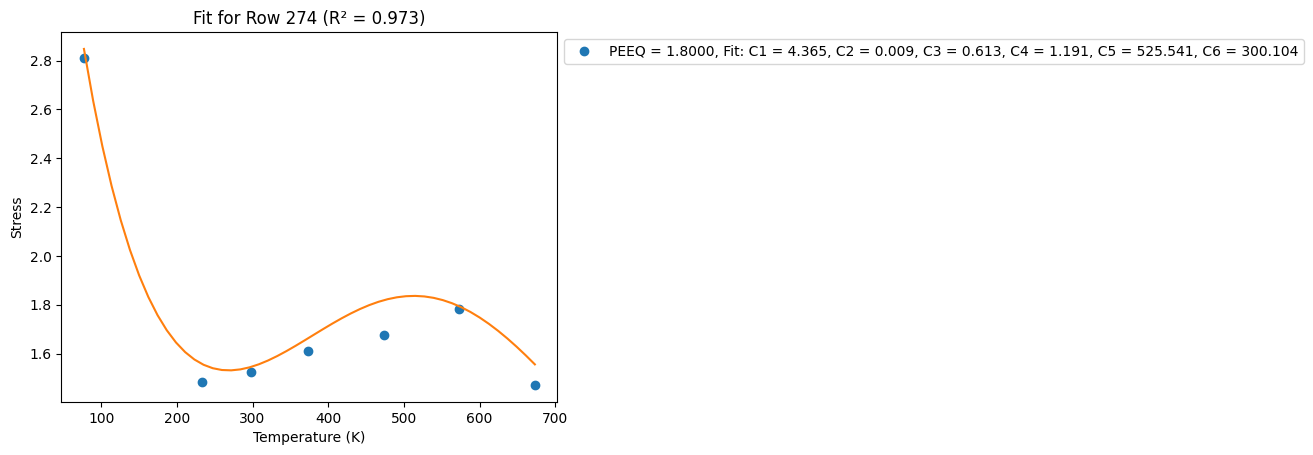

[2.81683352 1.48455007 1.52424907 1.61289265 1.67898709 1.78457343
 1.47261393]


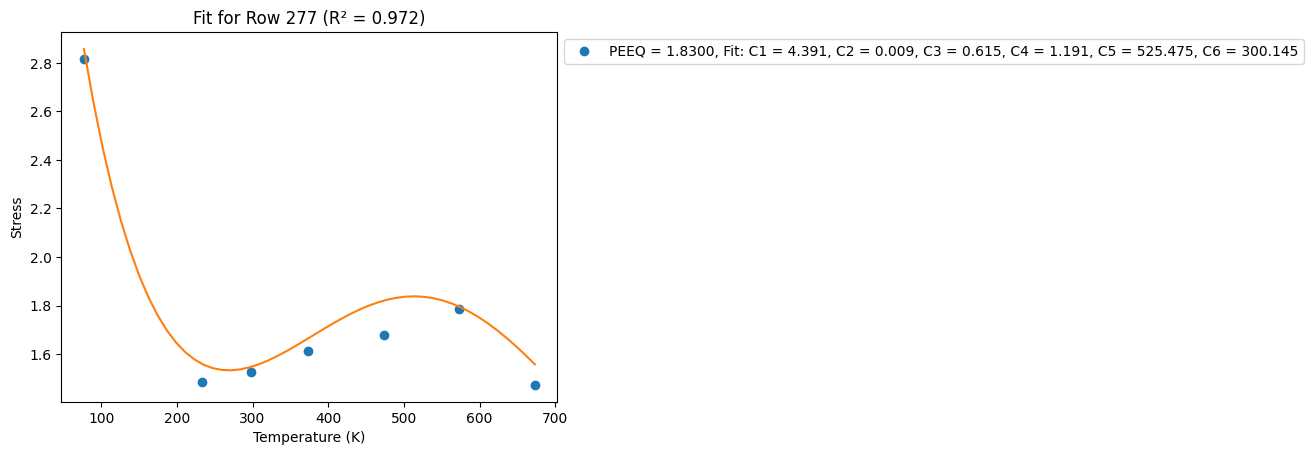

[2.82390055 1.48461303 1.52485258 1.61427745 1.68014979 1.7861858
 1.473876  ]


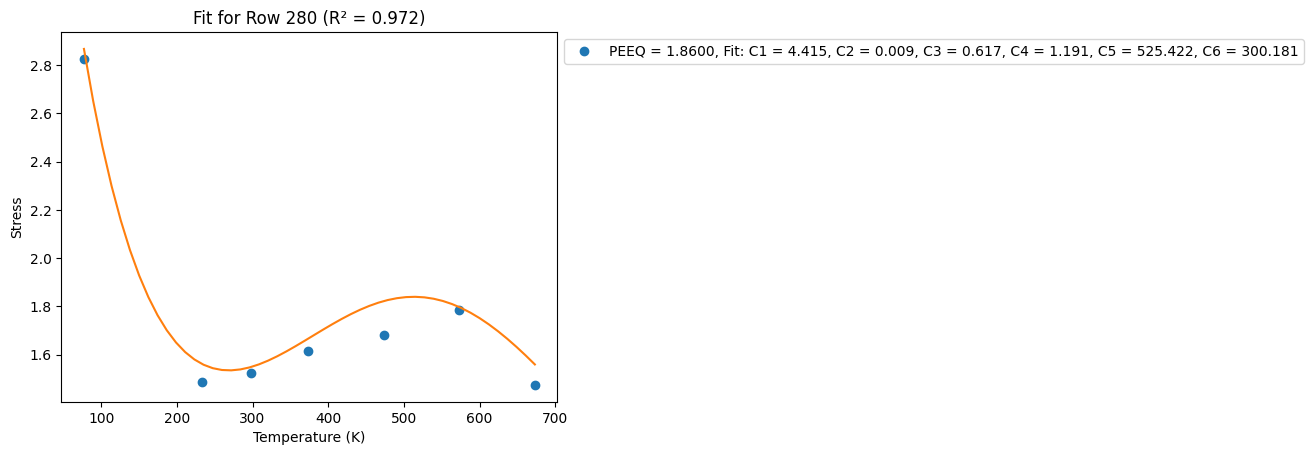

[2.83088875 1.4846741  1.52544437 1.61564001 1.68129204 1.78777071
 1.47511776]


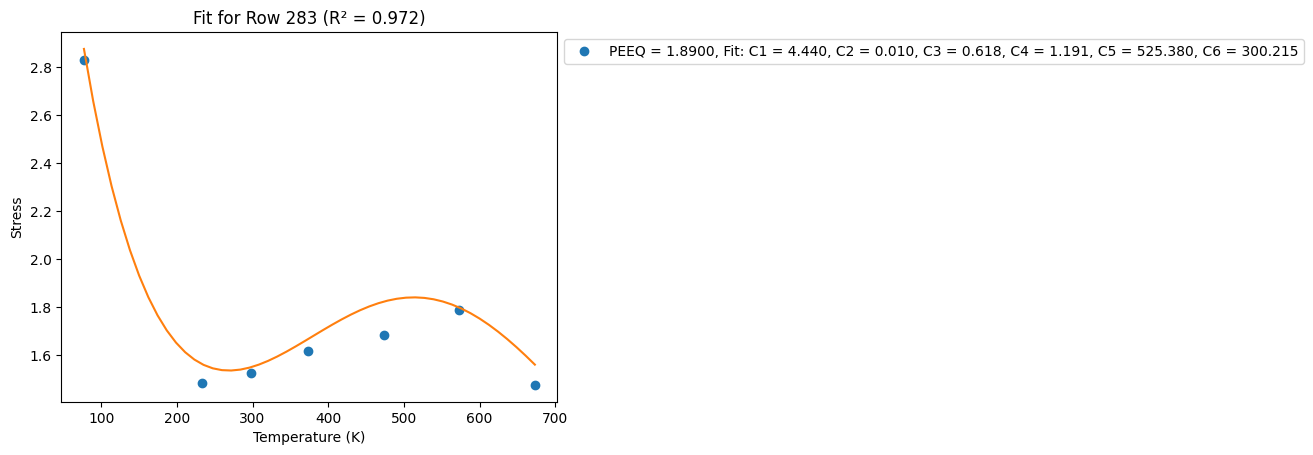

[2.83780023 1.48473339 1.52602484 1.61698103 1.68241451 1.78932908
 1.47633986]


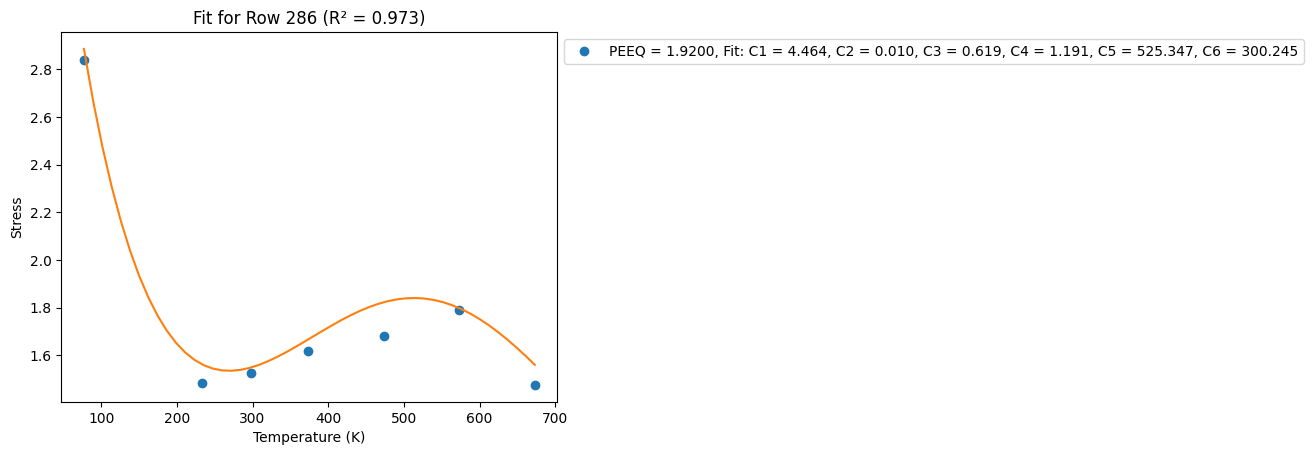

[2.84463701 1.48479096 1.52659438 1.61830118 1.68351784 1.79086175
 1.47754293]


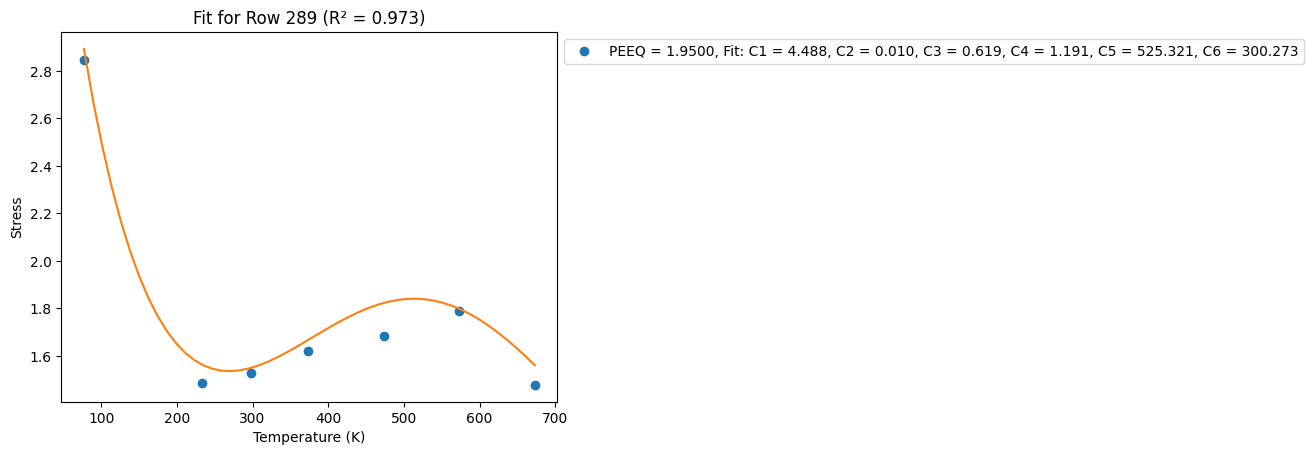

[2.85140105 1.4848469  1.52715337 1.61960109 1.68460265 1.79236953
 1.47872753]


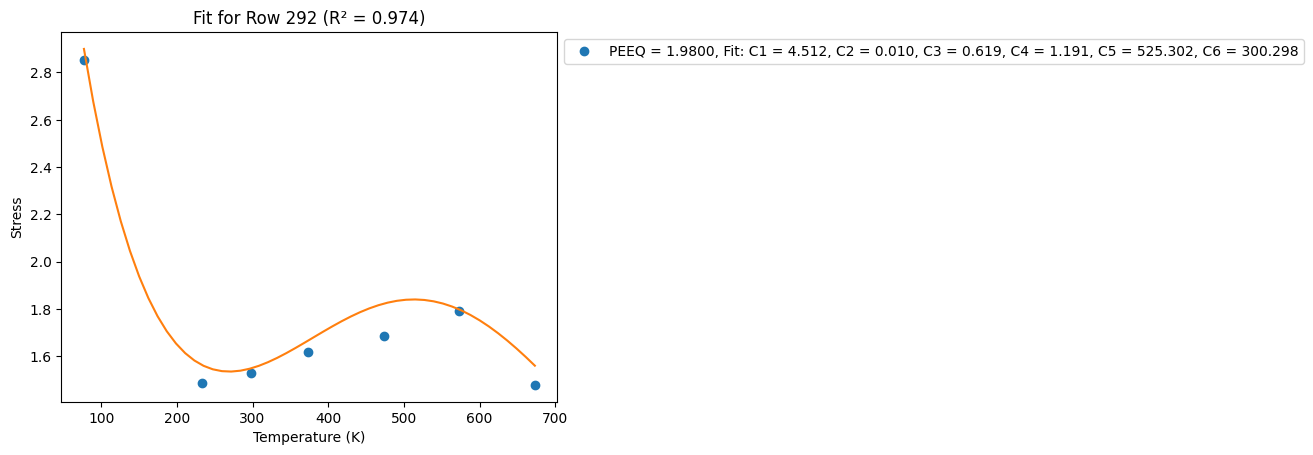

[2.85809421 1.48490127 1.52770216 1.62088138 1.68566953 1.7938532
 1.47989423]


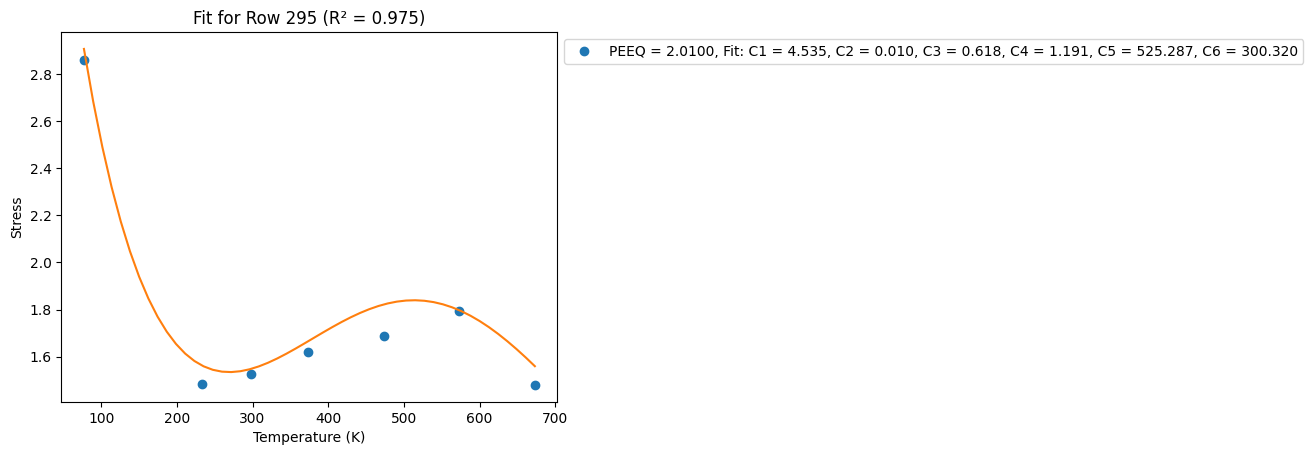

[2.86471827 1.48495415 1.52824108 1.62214264 1.68671904 1.79531349
 1.48104356]


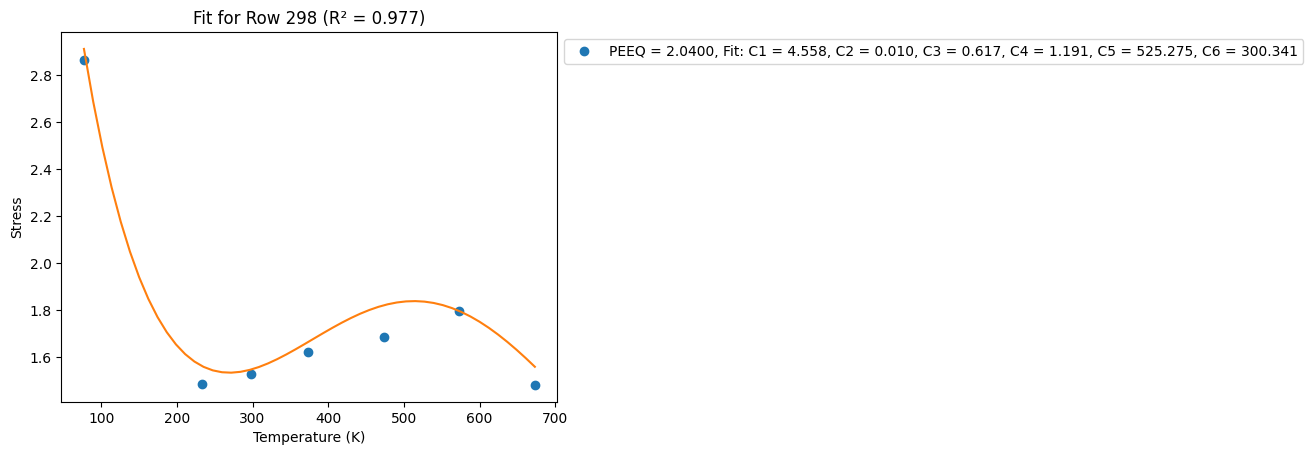

In [12]:
# Temperarute data points
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15])

# Temperature function
def f_func(T, cT1, cT2, cT3, cT4, cT5, cT6):
    return cT1*(np.exp(-cT2*T))+cT3+cT4*(np.exp(-((T-cT5)/cT6)**2))

for j, i in enumerate(np.arange(1,300,3)):
    T_fit = np.linspace(np.min(T), np.max(T), 50)
    [C1, C2, C3, C4, C5, C6] = fitted_para.iloc[i, 1:]
    y = stress_data.iloc[i, 8:].values
    print(y)
    gaussian_fit = f_func(T_fit, C1, C2, C3, C4, C5, C6)

    # Calculate residuals for error estimation
    residuals = y - f_func(T, C1, C2, C3, C4, C5, C6)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    plt.plot(T, y, 'o', T_fit, gaussian_fit)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Stress")
    plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
    plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
else:
    str(0)